In [ ]:
!pip install sentence-transformers


     |████████████████████████████████| 92kB 10.1MB/s 
     |████████████████████████████████| 2.5MB 32.5MB/s 
     |████████████████████████████████| 1.2MB 39.4MB/s 
     |████████████████████████████████| 3.3MB 33.0MB/s 
     |████████████████████████████████| 901kB 42.7MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.0.0-cp37-none-any.whl size=126711 sha256=4cee2015e0811db153886f905c429cc94fc94dbf47d835a8e2776776ee5a0f48
  Stored in directory: /root/.cache/pip/wheels/38/d2/98/d191289a877a34c68aa67e05179521e060f96394a3e9336be6
Successfully built sentence-transformers
ERROR: transformers 4.8.2 has requirement huggingface-hub==0.0.12, but you'll have huggingface-hub 0.0.13 which is incompatible.


In [ ]:
import pandas as pd
import numpy as np
import os 
import ast
import sentence_transformers  #### This is the package which we will use for encoding recipes using pretrained embedding
import matplotlib.pyplot as plt 
import networkx as nx #### Network x will be used to create graph based algorithms
import pickle ### We will use pickleto save files for later access
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity ### Cosine Similary
from scipy import sparse ### Sparse Matrix
model = SentenceTransformer('bert-large-nli-stsb-mean-tokens') ### We will use this senetnce encodings

In [ ]:
pd.set_option('max_colwidth', 400) 

# BERT 

In [ ]:
### Read the interactions csv as required 
interactions = pd.read_csv('/content/drive/MyDrive/Food.com Recipes and Interactions/datasets/RAW_interactions.csv')

print ("Lets look at the basic stats about the data")
print ("The shape of the data is")
print (interactions.shape)
print (" The columns in the data are as follows")
print (interactions.columns)
print (" The first few columns are ")
print (interactions.head(5))

Lets look at the basic stats about the data
The shape of the data is
(1132367, 5)
 The columns in the data are as follows
Index(['user_id', 'recipe_id', 'date', 'rating', 'review'], dtype='object')
 The first few columns are 
   user_id  ...                                             review
0    38094  ...  Great with a salad. Cooked on top of stove for...
1  1293707  ...  So simple, so delicious! Great for chilly fall...
2     8937  ...  This worked very well and is EASY.  I used not...
3   126440  ...  I made the Mexican topping and took it to bunk...
4    57222  ...  Made the cheddar bacon topping, adding a sprin...

[5 rows x 5 columns]


In [ ]:
interactions['rating'].value_counts()

5    816364
4    187360
0     60847
3     40855
2     14123
1     12818
Name: rating, dtype: int64

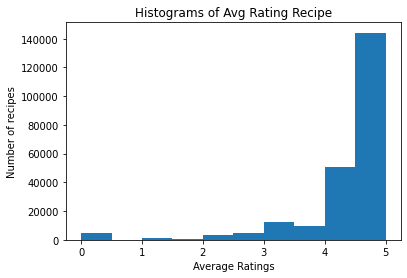

In [ ]:
### Interestingly most of the recipes are rated at highest rating. 
interactions.groupby('recipe_id')['rating'].mean().reset_index().rating.plot(kind ='hist',title='Histograms of Avg Rating Recipe')
plt.xlabel("Average Ratings")
plt.ylabel("Number of recipes")
plt.show()

In [ ]:
### Print for the poc purposes we will restrict
g = {'rating' : ['mean'],'user_id' : ['nunique']}
int_summary = interactions.groupby(['recipe_id']).agg(g).reset_index()
### Its gives a muti index output convert it to single index by cobining bothe level
ind = pd.Index([e[0] + "_" +e[1] for e in int_summary.columns.tolist()])
### Assign the column names 
int_summary.columns = ind
int_summary.columns = ['recipe_id', 'rating_mean', 'user_id_nunique']
### We will keep only those recipes in considerstaion which have been reviewed by more than 2 people
int_summary_94k = int_summary[ (int_summary['user_id_nunique'] > 2)]

In [ ]:
recipes = pd.read_csv('/content/drive/MyDrive/Food.com Recipes and Interactions/datasets/RAW_recipes.csv')
print (recipes.columns)

Index(['name', 'id', 'minutes', 'contributor_id', 'submitted', 'tags',
       'nutrition', 'n_steps', 'steps', 'description', 'ingredients',
       'n_ingredients'],
      dtype='object')


In [ ]:
filter_recipe = pd.merge(recipes,int_summary_94k,right_on = ['recipe_id'],left_on = ['id'],how = 'inner')

In [ ]:
filter_recipe

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,recipe_id,rating_mean,user_id_nunique
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7,137739,5.000000,3
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6,31490,3.500000,4
2,beat this banana bread,75452,70,15892,2003-11-04,"['weeknight', 'time-to-make', 'course', 'main-...","[2669.3, 160.0, 976.0, 107.0, 62.0, 310.0, 138.0]",12,"['preheat oven to 350 degrees', 'butter two 9x...",from ann hodgman's,"['sugar', 'unsalted butter', 'bananas', 'eggs'...",9,75452,4.400000,5
3,better than sex strawberries,42198,1460,41531,2002-10-03,"['weeknight', 'time-to-make', 'course', 'main-...","[734.1, 66.0, 199.0, 10.0, 10.0, 117.0, 28.0]",8,['crush vanilla wafers into fine crumbs and li...,simple but sexy. this was in my local newspape...,"['vanilla wafers', 'butter', 'powdered sugar',...",7,42198,3.800000,5
4,better then bush s baked beans,67547,2970,85627,2003-07-26,"['weeknight', 'time-to-make', 'course', 'main-...","[462.4, 28.0, 214.0, 69.0, 14.0, 29.0, 23.0]",9,['in a very large sauce pan cover the beans an...,i'd have to say that this is a labor of love d...,"['great northern bean', 'chicken bouillon cube...",13,67547,3.900000,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94559,zwiebelwhe swiss onion tart,410985,165,993604,2010-01-30,"['weeknight', 'time-to-make', 'course', 'main-...","[440.1, 49.0, 15.0, 10.0, 22.0, 90.0, 9.0]",38,"['crust:', 'pulse flour , baking powder , and ...",a delicious bacon-studded tart.,"['flour', 'baking powder', 'kosher salt', 'uns...",13,410985,1.666667,3
94560,zydeco salad,367912,5,79877,2009-04-25,"['15-minutes-or-less', 'time-to-make', 'prepar...","[14.1, 0.0, 8.0, 0.0, 1.0, 0.0, 1.0]",4,['place the lettuce on a platter or serving di...,"recipe courtesy of b&c seafood, vacherie, la a...","['iceberg lettuce', 'tomatoes', '3 bean mix', ...",4,367912,5.000000,3
94561,zydeco soup,486161,60,227978,2012-08-29,"['ham', '60-minutes-or-less', 'time-to-make', ...","[415.2, 26.0, 34.0, 26.0, 44.0, 21.0, 15.0]",7,"['heat oil in a 4-quart dutch oven', 'add cele...",this is a delicious soup that i originally fou...,"['celery', 'onion', 'green sweet pepper', 'gar...",22,486161,5.000000,6
94562,zydeco ya ya deviled eggs,308080,40,37779,2008-06-07,"['60-minutes-or-less', 'time-to-make', 'course...","[59.2, 6.0, 2.0, 3.0, 6.0, 5.0, 0.0]",7,"['in a bowl , combine the mashed yolks and may...","deviled eggs, cajun-style","['hard-cooked eggs', 'mayonnaise', 'dijon must...",8,308080,5.000000,5


In [ ]:
### The steps recipe is in list. We will combine list into one string
filter_recipe['dish_recipe'] = filter_recipe['steps'].apply(lambda x : " ".join(ast.literal_eval(x)))

In [ ]:
filter_recipe.to_csv('/content/drive/MyDrive/Food.com Recipes and Interactions/bert/filter_recipe.csv')

In [ ]:
#dataa=pd.read_csv('/content/drive/MyDrive/Food.com Recipes and Interactions/bert/filter_recipe.csv')
#dataa

,Unnamed: 0,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,recipe_id,rating_mean,user_id_nunique,dish_recipe
0,0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7,137739,5.000000,3,make a choice and proceed with recipe dependin...
1,1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6,31490,3.500000,4,preheat oven to 425 degrees f press dough into...
2,2,beat this banana bread,75452,70,15892,2003-11-04,"['weeknight', 'time-to-make', 'course', 'main-...","[2669.3, 160.0, 976.0, 107.0, 62.0, 310.0, 138.0]",12,"['preheat oven to 350 degrees', 'butter two 9x...",from ann hodgman's,"['sugar', 'unsalted butter', 'bananas', 'eggs'...",9,75452,4.400000,5,"preheat oven to 350 degrees butter two 9x5"" lo..."
3,3,better than sex strawberries,42198,1460,41531,2002-10-03,"['weeknight', 'time-to-make', 'course', 'main-...","[734.1, 66.0, 199.0, 10.0, 10.0, 117.0, 28.0]",8,['crush vanilla wafers into fine crumbs and li...,simple but sexy. this was in my local newspape...,"['vanilla wafers', 'butter', 'powdered sugar',...",7,42198,3.800000,5,crush vanilla wafers into fine crumbs and line...
4,4,better then bush s baked beans,67547,2970,85627,2003-07-26,"['weeknight', 'time-to-make', 'course', 'main-...","[462.4, 28.0, 214.0, 69.0, 14.0, 29.0, 23.0]",9,['in a very large sauce pan cover the beans an...,i'd have to say that this is a labor of love d...,"['great northern bean', 'chicken bouillon cube...",13,67547,3.900000,10,in a very large sauce pan cover the beans and ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94559,94559,zwiebelwhe swiss onion tart,410985,165,993604,2010-01-30,"['weeknight', 'time-to-make', 'course', 'main-...","[440.1, 49.0, 15.0, 10.0, 22.0, 90.0, 9.0]",38,"['crust:', 'pulse flour , baking powder , and ...",a delicious bacon-studded tart.,"['flour', 'baking powder', 'kosher salt', 'uns...",13,410985,1.666667,3,"crust: pulse flour , baking powder , and salt ..."
94560,94560,zydeco salad,367912,5,79877,2009-04-25,"['15-minutes-or-less', 'time-to-make', 'prepar...","[14.1, 0.0, 8.0, 0.0, 1.0, 0.0, 1.0]",4,['place the lettuce on a platter or serving di...,"recipe courtesy of b&c seafood, vacherie, la a...","['iceberg lettuce', 'tomatoes', '3 bean mix', ...",4,367912,5.000000,3,place the lettuce on a platter or serving dish...
94561,94561,zydeco soup,486161,60,227978,2012-08-29,"['ham', '60-minutes-or-less', 'time-to-make', ...","[415.2, 26.0, 34.0, 26.0, 44.0, 21.0, 15.0]",7,"['heat oil in a 4-quart dutch oven', 'add cele...",this is a delicious soup that i originally fou...,"['celery', 'onion', 'green sweet pepper', 'gar...",22,486161,5.000000,6,"heat oil in a 4-quart dutch oven add celery , ..."
94562,94562,zydeco ya ya deviled eggs,308080,40,37779,2008-06-07,"['60-minutes-or-less', 'time-to-make', 'course...","[59.2, 6.0, 2.0, 3.0, 6.0, 5.0, 0.0]",7,"['in a bowl , combine the mashed yolks and may...","deviled eggs, cajun-style","['hard-cooked eggs', 'mayonnaise', 'dijon must...",8,308080,5.000000,5,"in a bowl , combine the mashed yolks and mayon..."


In [ ]:
# ## We will encode the recipes and store it in pickle file
encodings_recipe= model.encode(filter_recipe['dish_recipe'])
pickle.dump(encodings_recipe,open("recipe_embedding.pickle",'wb'))


In [ ]:
type(encodings_recipe)

numpy.ndarray

In [ ]:
#### Load the pickle files of encoding and create a dataframe out of it
encodings_recipe_df = pickle.load(open("recipe_embedding.pickle",'rb'))
print ("Encoding are loaded")
data_encoding = pd.DataFrame(encodings_recipe_df)

Encoding are loaded


In [ ]:
### As we don't have enough memory create cosine similary for only 5000 recipes
encoding_sparse = sparse.csr_matrix(encodings_recipe_df[0:10000])

In [ ]:
type(encoding_sparse)

scipy.sparse.csr.csr_matrix

In [ ]:
# similarities = cosine_similarity(encoding_sparse)
# print('pairwise dense output:\n {}\n'.format(similarities))

#also can output sparse matrices
import datetime
time = datetime.datetime.now()
print (time)
similarities_sparse = cosine_similarity(encoding_sparse)
# print('pairwise sparse output:\n {}\n'.format(similarities_sparse))
print ("Time taken is :",)
print (datetime.datetime.now()-time)

2021-06-14 21:07:40.309003
Time taken is :
0:03:37.644449


In [ ]:
similarities_sparse

array([[0.99999976, 0.52895933, 0.6715446 , ..., 0.60637575, 0.59967035,
        0.6556583 ],
       [0.52895933, 0.9999996 , 0.70287836, ..., 0.72232044, 0.53975564,
        0.63688946],
       [0.6715446 , 0.70287836, 0.99999994, ..., 0.65624887, 0.5378876 ,
        0.77025324],
       ...,
       [0.60637575, 0.72232044, 0.65624887, ..., 0.99999976, 0.5151913 ,
        0.72195905],
       [0.59967035, 0.53975564, 0.5378876 , ..., 0.5151913 , 1.0000002 ,
        0.4756495 ],
       [0.6556583 , 0.63688946, 0.77025324, ..., 0.72195905, 0.4756495 ,
        1.0000001 ]], dtype=float32)

In [ ]:
similarities_sparse_df=pd.DataFrame(similarities_sparse)
similarities_sparse_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,9960,9961,9962,9963,9964,9965,9966,9967,9968,9969,9970,9971,9972,9973,9974,9975,9976,9977,9978,9979,9980,9981,9982,9983,9984,9985,9986,9987,9988,9989,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,1.000000,0.528959,0.671545,0.645898,0.598227,0.548111,0.658176,0.623684,0.637613,0.751083,0.667753,0.669321,0.542882,0.611158,0.632188,0.659076,0.599597,0.568605,0.396895,0.564004,0.618564,0.478696,0.598787,0.624654,0.557103,0.587540,0.626007,0.631018,0.676225,0.476559,0.665651,0.533998,0.529722,0.657142,0.559678,0.631970,0.726918,0.525963,0.434532,0.677307,...,0.632238,0.570780,0.571063,0.715663,0.571401,0.383406,0.561764,0.590961,0.676430,0.530622,0.621306,0.637153,0.663850,0.661461,0.646396,0.595638,0.540076,0.550362,0.577979,0.335420,0.609687,0.616109,0.695110,0.563458,0.574385,0.643505,0.556971,0.675993,0.514544,0.604715,0.616745,0.636461,0.575185,0.592286,0.669191,0.690462,0.683399,0.606376,0.599670,0.655658
1,0.528959,1.000000,0.702878,0.593603,0.577684,0.591075,0.661492,0.573966,0.568733,0.624170,0.646727,0.617249,0.313245,0.531679,0.700766,0.718704,0.607476,0.690563,0.490641,0.666945,0.625758,0.599632,0.664137,0.561496,0.707337,0.548533,0.694524,0.662378,0.739186,0.567051,0.703020,0.679087,0.404625,0.662832,0.486201,0.625233,0.481550,0.398024,0.444938,0.528063,...,0.615383,0.642662,0.547697,0.651215,0.633804,0.344354,0.478519,0.557870,0.680953,0.468085,0.667908,0.669199,0.560853,0.576454,0.635129,0.701924,0.756460,0.476056,0.450610,0.322136,0.611422,0.668641,0.669446,0.638680,0.637886,0.675199,0.745863,0.596765,0.502288,0.730701,0.511183,0.605854,0.738380,0.605720,0.729036,0.636905,0.613865,0.722320,0.539756,0.636889
2,0.671545,0.702878,1.000000,0.705688,0.691924,0.488929,0.710086,0.720531,0.488493,0.710443,0.610423,0.788208,0.457954,0.503492,0.708983,0.641031,0.758740,0.644769,0.504998,0.740683,0.611225,0.680095,0.634383,0.501286,0.625005,0.580514,0.794855,0.768334,0.752253,0.655631,0.680090,0.798724,0.446139,0.598590,0.605943,0.678183,0.566202,0.484805,0.586259,0.649578,...,0.692329,0.722151,0.498139,0.781136,0.719920,0.436675,0.654416,0.692523,0.645705,0.677423,0.779863,0.776477,0.534895,0.645062,0.771161,0.755780,0.543727,0.601924,0.599879,0.335541,0.783373,0.536819,0.709119,0.531950,0.530384,0.615949,0.593898,0.677048,0.641546,0.812101,0.620540,0.739325,0.576731,0.586269,0.633902,0.639634,0.813972,0.656249,0.537888,0.770253
3,0.645898,0.593603,0.705688,1.000000,0.561743,0.403687,0.671498,0.643159,0.496834,0.595167,0.571884,0.637013,0.431848,0.421562,0.587800,0.588393,0.703275,0.518164,0.533766,0.568269,0.532474,0.537182,0.500461,0.507761,0.485641,0.542124,0.768876,0.691336,0.682436,0.508847,0.557048,0.622803,0.385665,0.539481,0.476328,0.751769,0.531807,0.494799,0.395945,0.512697,...,0.719126,0.526609,0.461551,0.729060,0.617965,0.526219,0.600326,0.599252,0.594008,0.650363,0.719971,0.757596,0.644288,0.557663,0.696702,0.750006,0.417098,0.651426,0.630014,0.509842,0.614790,0.488130,0.597784,0.398674,0.446840,0.605904,0.528666,0.521984,0.570710,0.700904,0.608212,0.722609,0.566653,0.414181,0.565641,0.570448,0.746430,0.590263,0.547477,0.652434
4,0.598227,0.577684,0.691924,0.561743,1.000000,0.588066,0.657126,0.711356,0.531850,0.681122,0.701760,0.696823,0.507893,0.599614,0.653813,0.638955,0.605031,0.573895,0.458921,0.733937,0.622683,0.676769,0.707706,0.588407,0.604925,0.570215,0.663181,0.648633,0.731533,0.705497,0.662228,0.668154,0.579970,0.644004,0.600823,0.621554,0.636632,0.360927,0.537933,0.669595,...,0.703598,0.700774,0.593203,0.709554,0.640358,0.335677,0.535338,0.726987,0.681315,0.555505,0.725776,0.691520,0.510851,0.583930,0.761203,0.542907,0.568657,0.486726,0.454694,0.296441,0.660774,0.650119,0.691358,0.611205,0.607675,0.622763,0.572763,0.722744,0.614495,0.684180,0.595843,0.602275,0.530897,0.631683,0.582762,0.680112,0.650158,0.717504,0.484806,0.693060
...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [ ]:
similarities_sparse_df.to_csv('/content/drive/MyDrive/Food.com Recipes and Interactions/bert/similarities_sparse_df.csv')

In [ ]:
### Convert the pickle file to datafarme and dump
df1 = pd.DataFrame(similarities_sparse)
pickle.dump(df1,open('similarities_sparse.pickle','wb'))

In [ ]:
data_similarity = df1.unstack().reset_index() 


In [ ]:
data_similarity.columns = ['recipe1','recipe2','cosine_similarity']

In [ ]:
data_similarity = data_similarity[data_similarity['cosine_similarity']<0.9999]
data_similarity = data_similarity[data_similarity['cosine_similarity']>0.6]
print (data_similarity.shape)

(54944608, 3)


In [ ]:
recipe_dict = {}
for j,i in enumerate(filter_recipe['name']):
    recipe_dict[j] = i
print ("Dictionary is created :")
    

Dictionary is created :


In [ ]:
data_similarity['recipe1_name'] = data_similarity['recipe1'].map(recipe_dict)
data_similarity['recipe2_name'] = data_similarity['recipe2'].map(recipe_dict)

In [ ]:
data_similarity.head(5)


,recipe1,recipe2,cosine_similarity,recipe1_name,recipe2_name
2,0,2,0.671545,arriba baked winter squash mexican style,beat this banana bread
3,0,3,0.645898,arriba baked winter squash mexican style,better than sex strawberries
6,0,6,0.658176,arriba baked winter squash mexican style,chile rellenos
7,0,7,0.623684,arriba baked winter squash mexican style,chinese candy
8,0,8,0.637613,arriba baked winter squash mexican style,chinese chop suey


# REAL BERT 


**ONLY THIS CODE IS NEEDED FOR COMPARISONS**

In [ ]:
data_similarity=pd.read_csv('/content/drive/MyDrive/Food.com Recipes and Interactions/bert/data_similarity.csv')

In [ ]:
data_similarity['similarity_rank'] = data_similarity.groupby(['recipe1'])['cosine_similarity'].rank("dense", ascending=False)

In [ ]:
data_similarity.head(20)

,Unnamed: 0,recipe1,recipe2,cosine_similarity,recipe1_name,recipe2_name,similarity_rank
0,2,0,2,0.671545,arriba baked winter squash mexican style,beat this banana bread,1740.0
1,3,0,3,0.645898,arriba baked winter squash mexican style,better than sex strawberries,3169.0
2,6,0,6,0.658176,arriba baked winter squash mexican style,chile rellenos,2463.0
3,7,0,7,0.623684,arriba baked winter squash mexican style,chinese candy,4543.0
4,8,0,8,0.637613,arriba baked winter squash mexican style,chinese chop suey,3660.0
5,9,0,9,0.751083,arriba baked winter squash mexican style,cream of spinach soup,75.0
6,10,0,10,0.667753,arriba baked winter squash mexican style,crispy crunchy chicken,1962.0
7,11,0,11,0.669321,arriba baked winter squash mexican style,easiest ever hollandaise sauce,1865.0
8,13,0,13,0.611158,arriba baked winter squash mexican style,fool the meat eaters chili,5305.0
9,14,0,14,0.632188,arriba baked winter squash mexican style,fried potatoes,4011.0


In [ ]:
data_similarity = data_similarity[data_similarity['similarity_rank'] <= 10].reset_index()

In [ ]:
data_similarity.head(20)

,index,Unnamed: 0,recipe1,recipe2,cosine_similarity,recipe1_name,recipe2_name,similarity_rank
0,572,1087,0,1087,0.824837,arriba baked winter squash mexican style,acorn squash a la kree,3.0
1,575,1090,0,1090,0.824706,arriba baked winter squash mexican style,acorn squash bisque,4.0
2,579,1094,0,1094,0.807394,arriba baked winter squash mexican style,acorn squash roasted with applesauce,7.0
3,586,1101,0,1101,0.817159,arriba baked winter squash mexican style,acorn squash with pineapple,5.0
4,587,1102,0,1102,0.813644,arriba baked winter squash mexican style,acorn squash with raisin sauce,6.0
5,2455,4184,0,4184,0.797381,arriba baked winter squash mexican style,aunt fanny s baked yellow squash,8.0
6,2597,4436,0,4436,0.793161,arriba baked winter squash mexican style,autumn baked acorn squash,10.0
7,3411,5816,0,5816,0.833334,arriba baked winter squash mexican style,baked delicata squash with lime butter,2.0
8,3807,6352,0,6352,0.835143,arriba baked winter squash mexican style,baked spaghetti squash with jalapeno cream,1.0
9,4642,7628,0,7628,0.796396,arriba baked winter squash mexican style,barefoot contessa s butternut squash risotto,9.0


In [ ]:
def find_similar_dishes(list_names):
    for i in list_names:
        dummy_data =  data_similarity[data_similarity['recipe1_name'] == i]
        print ("As you liked dish :",i)
        print ("You must try following 4 dishes with slight variations")
        dummy_data.sort_values(inplace = True,by =['similarity_rank']) 
        for j,i in enumerate(dummy_data['recipe2_name'].unique()):
            print ("             ", i)
            if j == 10:
                break


In [ ]:
import warnings
warnings.filterwarnings('ignore')
find_similar_dishes(['banana walnut cake','aaloo mattar   indian style peas and potatoes','avocado ranch burgers with smoked cheddar',
                    'bird s perfect baked potatoes','bird s ultimate taco salad'])

As you liked dish : banana walnut cake
You must try following 4 dishes with slight variations
              anna banana s birthday cake with chocolate fudge icing
              banana snack cake with delicious cream cheese frosting
              baby food pineapple coconut carrot cake
              banana walnut buttermilk bread
              apple s restaurant election day cookies
              banana white chocolate cake with icing   absolutely decadent
              banana snack cake
              banana  pineapple and coconut cake
              apple walnut pound cake
              banana banana bread
As you liked dish : aaloo mattar   indian style peas and potatoes
You must try following 4 dishes with slight variations
              aloo gobi
              asian barbecue chicken salad
              aloo mutter
              balti seitan madras
              aloo matar
              aloo palak  indian potatoes   spinach
              aloo channa chaat  tangy potato chickpea snack
 

# Comparisons (Some examples)

In [ ]:
import pandas as pd
raw_interactions= pd.read_csv("/content/drive/MyDrive/Food.com Recipes and Interactions/datasets/RAW_interactions.csv")
pp_users=pd.read_csv("/content/drive/MyDrive/Food.com Recipes and Interactions/datasets/PP_users.csv")
raw_recipes=pd.read_csv("/content/drive/MyDrive/Food.com Recipes and Interactions/datasets/RAW_recipes.csv")
pp_recipes=pd.read_csv("/content/drive/MyDrive/Food.com Recipes and Interactions/datasets/PP_recipes.csv")
interactions_train=pd.read_csv("/content/drive/MyDrive/Food.com Recipes and Interactions/datasets/interactions_train.csv")

## user 1

In [ ]:
#Choosing the user
user_x = pp_users.iloc[0:1,:] 
user_x

,u,techniques,items,n_items,ratings,n_ratings
0,0,"[8, 0, 0, 5, 6, 0, 0, 1, 0, 9, 1, 0, 0, 0, 1, 0, 5, 0, 0, 0, 3, 1, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 8, 0, 0, 8, 2, 2, 0, 0, 0, 3, 3, 1, 0, 5, 0, 0, 2, 1, 1, 0, 3, 1, 7, 2, 2]","[1118, 27680, 32541, 137353, 16428, 28815, 65803, 148743, 129939, 99377, 33025, 173660, 46706, 100515, 101276, 93176, 70383, 24204, 0, 172222, 19472, 90038, 84063, 71578, 11190, 58387, 27749, 101225, 85204, 89385, 161655]",31,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 4.0, 4.0, 5.0, 5.0, 4.0, 5.0, 5.0, 5.0, 5.0, 4.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]",31


In [ ]:
#Finding the recepies for that user
user_x_recipes=user_x['items']
user_x_recipes

lista=[]
for recipe in user_x_recipes:
  lista.append(recipe)

stringot= str(lista)
stringot=stringot[3:-3]
stringot=stringot.replace(',','')

user_x_recipes= [int(x) for x in stringot.split(' ')]

list_recipes = list()

for recipe in user_x_recipes:
  result = pp_recipes[pp_recipes['i'] == recipe]
  id = result.iloc[0]['id']
  recipe = raw_recipes[raw_recipes['id'] == id]
  name = recipe.iloc[0]['name']
  list_recipes.append(name)

list_recipes

['black beans with mango sauce',
 'oh my d lux chocolate chip cookies',
 'toasted orzo pilaf',
 'yummy n  easiest  warm blueberry sauce',
 'roasted asparagus   shiitake mushrooms',
 'bananas au gratin',
 'key lime cheesecake squares',
 'couscous with chickpeas',
 'sweet potato stew with orange juice and black beans',
 'easy creamy yogurt pie',
 'rocky mount chicken',
 'basil  cilantro and macadamia nut chicken',
 'beans  black eyed peas  and cashew salad',
 'quick broccoli slaw',
 'sauteed salmon with lime honey sauce',
 'portuguese pork ragout with sweet peppers',
 '2 step pumpkin cheesecake',
 'slow cooker hoppin  john',
 'white bean   green chile pepper soup',
 'lentil and orzo salad',
 'low carb key lime pie',
 'fried broccoli',
 'low fat chicken cassoulet',
 'oven fried eggplant  aubergine',
 'warm spinach salad',
 'veal cutlets with olive  tomato and anchovy sauce',
 'honey roasted pork loin',
 'squash casserole  charlotte s barclay cafeteria',
 'snow peas with red bell peppers',

In [ ]:
import warnings
warnings.filterwarnings('ignore')

#Finding the similar recipes based on the ones found before
find_similar_dishes(list_recipes)

As you liked dish : black beans with mango sauce
You must try following 4 dishes with slight variations
As you liked dish : oh my d lux chocolate chip cookies
You must try following 4 dishes with slight variations
As you liked dish : toasted orzo pilaf
You must try following 4 dishes with slight variations
As you liked dish : yummy n  easiest  warm blueberry sauce
You must try following 4 dishes with slight variations
              apple cider health drink
              aromatic sticky rice
              a a a absolutely the cranberry relish
              alton brown s cranberry dipping sauce
              bbq sauce
              banana butter
              baked beans for saturday s supper
              approximately  aurelio s pizza and pasta sauce
              arakas me anitho  greek dilled peas with peppers
              best creamed corn
As you liked dish : roasted asparagus   shiitake mushrooms
You must try following 4 dishes with slight variations
As you liked dish : bananas au

##Graph comparisons & Cuisine Similarity

In [ ]:
#random recipe of the user
raw_recipes[raw_recipes['name'] == '2 step pumpkin cheesecake']

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
1100,2 step pumpkin cheesecake,4764,30,1533,1999-11-21,"['30-minutes-or-less', 'time-to-make', 'course', 'main-ingredient', 'cuisine', 'preparation', 'occasion', 'north-american', 'desserts', 'eggs-dairy', 'american', 'refrigerator', 'dinner-party', 'cheesecake', 'dietary', 'equipment', 'number-of-servings']","[382.8, 37.0, 109.0, 15.0, 9.0, 59.0, 13.0]",6,"['beat cream cheese , pumpkin , sugar and pumpkin pie spice in large bowl with wire whisk or electric mixer until smooth', 'gently stir in whipped topping', 'spoon into crust', 'refrigerate three hours or until set', 'garnish as desired', 'store leftover cheesecake in refrigerator']",NaN,"['cream cheese', 'canned pumpkin', 'sugar', 'pumpkin pie spice', 'whipped topping', 'prepared graham cracker crust']",6


In [ ]:
pp_recipes[pp_recipes['id']==4764]


,id,i,name_tokens,ingredient_tokens,steps_tokens,techniques,calorie_level,ingredient_ids
24152,4764,70383,"[40480, 280, 1913, 18376, 32127, 40481]","[[4914, 6821], [19781, 18376], [6444], [18376, 7056, 16361], [6198, 31757], [3572, 8439, 23935, 19093]]","[40480, 40482, 2523, 4914, 6821, 240, 18376, 240, 6444, 488, 18376, 7056, 16361, 500, 1719, 5024, 556, 6859, 29369, 522, 7641, 34062, 1073, 3866, 40478, 40482, 2327, 9467, 500, 6198, 31757, 40478, 40482, 9082, 666, 19093, 40478, 40482, 8658, 746, 1203, 1808, 522, 1073, 1233, 40478, 40482, 1325, 15405, 557, 10114, 40478, 40482, 2961, 19656, 32127, 500, 9188, 40478, 40481]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]",1,"[1910, 1013, 6906, 5759, 7704, 3326]"


In [ ]:
node_ids.index('recipe_70383')


67713

In [ ]:
recipe_embed = list()
recipe_embed.append(node_embeddings[67713])
recipe_embed

[array([-0.11848816, -0.0444952 ,  0.1795096 ,  0.19100267,  0.20416504,
         0.17984307, -0.07731018, -0.22373529, -0.14964268,  0.03414068,
        -0.1776322 , -0.09585561,  0.06028374, -0.03723038,  0.00117532,
        -0.10105929, -0.07681686, -0.2194455 , -0.49866423, -0.12686186,
        -0.19033527,  0.14245649, -0.05151307, -0.1044755 ,  0.05276203,
         0.1534173 ,  0.11511216, -0.02616557, -0.40598014,  0.26883885,
        -0.06784684, -0.17889756, -0.21319209,  0.08774763,  0.01200689,
        -0.22457223, -0.14772323,  0.09009713, -0.20877378,  0.06752454,
        -0.2148048 ,  0.14111951, -0.19447497,  0.06050091,  0.11130998,
         0.18226278,  0.17381318, -0.21002899,  0.31990528, -0.01778483,
         0.08186248, -0.1725899 , -0.08208061,  0.00943122,  0.04795904,
         0.39709347, -0.01637525,  0.01583504,  0.0206532 , -0.10153794,
         0.0524677 , -0.13231575, -0.0963696 , -0.13199972,  0.17660417,
         0.00942617,  0.1609346 , -0.03242866,  0.0

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
similarities = cosine_similarity(recipe_embed, node_embeddings)
df = pd.DataFrame(similarities)

similarity = df.unstack().reset_index()
similarity.columns = ['recipe1','recipe2','cosine_similarity']
similarity


,recipe1,recipe2,cosine_similarity
0,0,0,0.127077
1,1,0,0.103544
2,2,0,0.162553
3,3,0,0.177408
4,4,0,0.189563
...,...,...,...
185972,185972,0,0.557836
185973,185973,0,0.620792
185974,185974,0,0.653838
185975,185975,0,0.645226


In [ ]:
similarity_top = similarity.sort_values(by=['cosine_similarity'], ascending=False)
similarity_top

,recipe1,recipe2,cosine_similarity
67713,67713,0,1.000000
175524,175524,0,0.932967
44711,44711,0,0.929337
137760,137760,0,0.929330
168294,168294,0,0.919423
...,...,...,...
1263,1263,0,0.082185
685,685,0,0.080717
154,154,0,0.071115
413,413,0,0.058766


In [ ]:
top10=similarity_top.head(11)
top10

,recipe1,recipe2,cosine_similarity
67713,67713,0,1.000000
175524,175524,0,0.932967
44711,44711,0,0.929337
137760,137760,0,0.929330
168294,168294,0,0.919423
93774,93774,0,0.907811
178848,178848,0,0.904498
155374,155374,0,0.901295
78698,78698,0,0.899473
156763,156763,0,0.891818


In [ ]:
recipe_names = list()
user_137_recipes = interactions_train[interactions_train['u'] == 0]['i'].values
node_is = list()

for recipe in top10['recipe1'].values:
  node_id = node_ids[int(recipe)]
  node_i = int(node_id[7:])
  node_is.append(node_i)
  if(node_i in user_137_recipes):
    print("YES, ",node_i)
  else:
    print("NO")
  recipe = pp_recipes[pp_recipes['i']== node_i]
  result = raw_recipes[raw_recipes['id'] == recipe.iloc[0]['id']]
  recipe_names.append(result.iloc[0]['name'])

recipe_names

YES,  70383
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO


['2 step pumpkin cheesecake',
 'big batch chocolate chip cookies',
 'easy crock pot chicken and tomato sauce',
 'linda s tuna burritos',
 'hot fudge pudding',
 'no knead french bread',
 'caramelized chocolate  banana and marshmallow sandwiches',
 'oatmeal   raisin bread  abm',
 'quick quiche  ww',
 'warm goat cheese dip',
 'sticky chilli chicken wings']

In [ ]:
other_users = interactions_train[interactions_train['i'] == 70383]['u'].values

In [ ]:
for user in other_users:
  for i in node_is:
    if (i in interactions_train[interactions_train['u'] == user]['i'].values):
      print("YES, recipe ", i, " and user ", user)

YES, recipe  70383  and user  0
YES, recipe  70383  and user  4730
YES, recipe  70383  and user  21809
YES, recipe  70383  and user  759
YES, recipe  70383  and user  4940
YES, recipe  70383  and user  4513
YES, recipe  70383  and user  417
YES, recipe  70383  and user  7450
YES, recipe  70383  and user  3729
YES, recipe  70383  and user  5355
YES, recipe  70383  and user  20687
YES, recipe  70383  and user  24058
YES, recipe  70383  and user  21845
YES, recipe  70383  and user  3705


## user 137 

In [ ]:
#Choosing the user

user_x = pp_users.iloc[137:138,:] 
user_x

,u,techniques,items,n_items,ratings,n_ratings
137,137,"[397, 7, 1, 123, 169, 1, 1, 27, 2, 310, 13, 29, 1, 2, 15, 0, 168, 0, 0, 22, 107, 22, 2, 61, 16, 0, 13, 27, 196, 25, 0, 9, 0, 189, 1, 5, 98, 28, 68, 2, 4, 27, 106, 159, 11, 2, 76, 13, 0, 13, 2, 2, 1, 49, 16, 81, 22, 57]","[102313, 41004, 40058, 26721, 156289, 11813, 14430, 126011, 25411, 110959, 22975, 74491, 68273, 103244, 79797, 39511, 29973, 83692, 100684, 11659, 17321, 83331, 37227, 78724, 137554, 22463, 175613, 118043, 76675, 32249, 80264, 83799, 9988, 21273, 139315, 91430, 70648, 172115, 140373, 49523, 126337, 142557, 65106, 22032, 47837, 29716, 46732, 141284, 35152, 70680, 46826, 24603, 164169, 16915, 16...",932,"[3.0, 5.0, 4.0, 5.0, 4.0, 5.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 3.0, 5.0, 5.0, 5.0, 5.0, 4.0, 5.0, 4.0, 5.0, 5.0, 5.0, 5.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 5.0, 5.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 0.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...",932


In [ ]:
#Finding the recepies for that user
user_x_recipes=user_x['items']
user_x_recipes

lista=[]
for recipe in user_x_recipes:
  lista.append(recipe)

stringot= str(lista)
stringot=stringot[3:-3]
stringot=stringot.replace(',','')

user_x_recipes= [int(x) for x in stringot.split(' ')]

list_recipes = list()

for recipe in user_x_recipes:
  result = pp_recipes[pp_recipes['i'] == recipe]
  id = result.iloc[0]['id']
  recipe = raw_recipes[raw_recipes['id'] == id]
  name = recipe.iloc[0]['name']
  list_recipes.append(name)

list_recipes

['kelly s spiral ham   swiss strombolis',
 'stuffed baked potato with cheese',
 'smoked sausage skillet',
 'sausage gravy hash browns bake',
 'comforting chicken croquettes',
 'pizza hut breadstick seasoning',
 'garlic spiked broccoli and mushrooms',
 'broccoli bakers',
 'spaghetti shrimp platter',
 'deviled crab',
 'unknownchef86 s very best dinner rolls',
 'another garlic chicken',
 'rustic italian bread abm',
 'snow cream in a blender',
 'grandma s penuche frosting',
 'extra cheesy crescent mozzarella wedges',
 'seven layer side dish',
 'mouth watering baked chicken',
 'heavenly  whole wheat  bread',
 'polynesian salad',
 'our favourite lemon loaf',
 'old fashioned shoofly cake',
 'chocolate thunder',
 'orange cream cheese chocolate chip cookies',
 'chicken bites with spice',
 'hot mexican spiced cocoa',
 'pay day bar cake',
 'hot chocolate deluxe',
 'the best french bread  bread machine',
 'no peeking stewed potatoes',
 'm m s fudge jumbles',
 'oven baked white rice   perfect every

In [ ]:
#Finding the similar recipes based on the ones found before

find_similar_dishes(list_recipes)

As you liked dish : kelly s spiral ham   swiss strombolis
You must try following 4 dishes with slight variations
As you liked dish : stuffed baked potato with cheese
You must try following 4 dishes with slight variations
As you liked dish : smoked sausage skillet
You must try following 4 dishes with slight variations
As you liked dish : sausage gravy hash browns bake
You must try following 4 dishes with slight variations
As you liked dish : comforting chicken croquettes
You must try following 4 dishes with slight variations
As you liked dish : pizza hut breadstick seasoning
You must try following 4 dishes with slight variations
As you liked dish : garlic spiked broccoli and mushrooms
You must try following 4 dishes with slight variations
As you liked dish : broccoli bakers
You must try following 4 dishes with slight variations
As you liked dish : spaghetti shrimp platter
You must try following 4 dishes with slight variations
As you liked dish : deviled crab
You must try following 4 dis

##Graph comparisons & Cuisine Similarity

In [ ]:
node_ids = np.load('/content/drive/MyDrive/Food.com Recipes and Interactions/bert/node_ids.npy')
node_ids

array(['user_9980', 'user_575', 'user_9338', ..., 'recipe_134979',
       'recipe_30235', 'recipe_99423'], dtype='<U13')

In [ ]:
node_embeddings = np.load('/content/drive/MyDrive/Food.com Recipes and Interactions/bert/node_embeddings.npy')
node_embeddings

array([[ 0.7458869 , -0.1953268 , -0.05857452, ...,  0.34101838,
        -0.14960316, -0.6334048 ],
       [ 0.19968241,  0.30542704,  0.2546549 , ..., -0.18635821,
        -0.64748657, -0.33575648],
       [-0.0270678 , -0.797587  , -0.45114055, ..., -0.3179598 ,
        -1.1719768 , -0.46557328],
       ...,
       [-0.02439426, -0.01322124,  0.03422837, ..., -0.05569395,
        -0.03193173,  0.00475547],
       [-0.01691001, -0.00535849,  0.01483367, ..., -0.04569783,
        -0.00363385,  0.01809129],
       [-0.03336621,  0.0097888 ,  0.00641282, ..., -0.0586611 ,
        -0.02303491, -0.00334182]], dtype=float32)

In [ ]:
node_ids = list(node_ids)
type(node_ids)

list

In [ ]:
raw_recipes[raw_recipes['name'] == 'baked chicken fingers']

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
13797,baked chicken fingers,18897,28,25467,2002-02-04,"['30-minutes-or-less', 'time-to-make', 'course', 'main-ingredient', 'preparation', 'occasion', 'appetizers', 'main-dish', 'poultry', 'oven', 'easy', 'beginner-cook', 'finger-food', 'kid-friendly', 'chicken', 'dietary', 'high-protein', 'low-carb', 'high-in-something', 'low-in-something', 'meat', 'equipment', 'presentation']","[261.8, 18.0, 9.0, 10.0, 52.0, 17.0, 3.0]",9,"['preheat oven to 400 degrees', 'in a medium glass or plastic bowl , combine chicken breast and buttermilk', 'cover and put in refrigerator for 10-15 minutes', 'combine corn flakes , italian seasoned breadcrumbs , garlic powder , oregano , and black pepper in large ziploc bag', 'after chicken is chilled , drain off liquid and add to ziploc bag , shaking to coat', 'add olive oil to shallow baki...","this is a recipe i created after trying several baked chicken finger recipes. i like this combination of seasonings, but it's always fun to try different things. you could use saltines, other crackers, other spices, etc!","['chicken breast', 'low-fat buttermilk', 'corn flakes', 'italian seasoned breadcrumbs', 'garlic powder', 'oregano', 'black pepper', 'olive oil']",8


In [ ]:
pp_recipes[pp_recipes['id']==18897]

,id,i,name_tokens,ingredient_tokens,steps_tokens,techniques,calorie_level,ingredient_ids
105725,18897,95770,"[40480, 12187, 5867, 1413, 40481]","[[5867, 5355], [954, 260, 4739, 6796, 5940], [8289, 14071], [8300, 21137, 31950, 17169], [15022, 8361], [7, 4344, 6741], [1301, 11332], [10444, 6020]]","[40480, 40482, 729, 2525, 10906, 485, 26641, 9378, 40478, 40482, 500, 246, 11868, 1846, 522, 4438, 5024, 240, 23667, 5867, 5355, 488, 6796, 5940, 40478, 40482, 2454, 488, 1072, 500, 9188, 562, 5895, 260, 7648, 1571, 40478, 40482, 23667, 8289, 14071, 240, 8300, 21137, 31950, 17169, 240, 15022, 8361, 240, 7, 4344, 6741, 240, 488, 1301, 11332, 500, 1719, 3385, 4904, 263, 2165, 40478, 40482, 861, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",1,"[1252, 869, 1810, 3939, 3217, 5106, 590, 5006]"


In [ ]:
node_ids.index('recipe_95770')

120894

In [ ]:
recipe_embed = list()
recipe_embed.append(node_embeddings[120894])
recipe_embed

[array([-0.16942751, -0.11708811,  0.1176399 ,  0.18029541,  0.19153544,
         0.05638989, -0.26096702, -0.21271674, -0.248657  ,  0.11687725,
         0.05091063, -0.11553949,  0.01336409, -0.01661552, -0.17253546,
         0.02580159, -0.04520511, -0.1431504 , -0.26973304, -0.07852028,
        -0.12217541,  0.01844631, -0.0144522 , -0.24884789,  0.11566229,
        -0.02891147,  0.00219465, -0.08082515, -0.13811107,  0.1622209 ,
        -0.04917533, -0.15901934,  0.01862823,  0.05739038, -0.00470986,
        -0.09329236, -0.2742744 ,  0.12388962,  0.01086902,  0.19972846,
        -0.02637674,  0.17114373, -0.06591561,  0.19670537, -0.13802892,
        -0.1398863 , -0.02748814,  0.06261433,  0.23634845, -0.03041889,
         0.06747205, -0.07855435, -0.22673811, -0.20084321, -0.01265254,
         0.44554287, -0.0584897 ,  0.08929121,  0.11032348, -0.07840879,
         0.3071105 , -0.04190081, -0.02511453, -0.1316643 , -0.00294103,
         0.07219556,  0.10156369,  0.06241486, -0.1

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

similarities = cosine_similarity(recipe_embed, node_embeddings)

df = pd.DataFrame(similarities)

similarity = df.unstack().reset_index()
similarity.columns = ['recipe1','recipe2','cosine_similarity']
similarity

,recipe1,recipe2,cosine_similarity
0,0,0,0.280596
1,1,0,0.298903
2,2,0,0.301054
3,3,0,0.318720
4,4,0,0.292856
...,...,...,...
185972,185972,0,0.758055
185973,185973,0,0.774658
185974,185974,0,0.818921
185975,185975,0,0.835174


In [ ]:
similarity_top = similarity.sort_values(by=['cosine_similarity'], ascending=False)
similarity_top

,recipe1,recipe2,cosine_similarity
120894,120894,0,1.000000
184978,184978,0,0.945929
180625,180625,0,0.944811
162490,162490,0,0.942649
136301,136301,0,0.940216
...,...,...,...
369,369,0,0.186329
664,664,0,0.177348
147,147,0,0.175537
73,73,0,0.170220


In [ ]:
top10=similarity_top.head(11)
top10

,recipe1,recipe2,cosine_similarity
120894,120894,0,1.000000
184978,184978,0,0.945929
180625,180625,0,0.944811
162490,162490,0,0.942649
136301,136301,0,0.940216
163666,163666,0,0.938024
154811,154811,0,0.936852
139321,139321,0,0.936481
122662,122662,0,0.936351
156994,156994,0,0.936004


In [ ]:
recipe_names = list()
user_137_recipes = interactions_train[interactions_train['u'] == 137]['i'].values
node_is = list()

for recipe in top10['recipe1'].values:
  node_id = node_ids[int(recipe)]
  node_i = int(node_id[7:])
  node_is.append(node_i)
  if(node_i in user_137_recipes):
    print("YES, ",node_i)
  else:
    print("NO")
  recipe = pp_recipes[pp_recipes['i']== node_i]
  result = raw_recipes[raw_recipes['id'] == recipe.iloc[0]['id']]
  recipe_names.append(result.iloc[0]['name'])

recipe_names

YES,  95770
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO


['baked chicken fingers',
 'cuban black bean soup with cod  crock pot',
 'cream of anything soup mix substitute',
 'best and easiest waffles',
 'herbed focaccia bread',
 'olive garden spaghetti carbonara',
 'blt salad with garlic croutons',
 'crescent brunch bake',
 'simply the best tacos',
 'balsamic mashed sweet potatoes',
 'whisper']


users that cooked the recipe baked chicken


In [ ]:
other_users = interactions_train[interactions_train['i'] == 95770]['u'].values

In [ ]:
node_is

[95770,
 100665,
 47676,
 55752,
 100954,
 71558,
 121182,
 55841,
 58469,
 90314,
 90275]

In [ ]:
for user in other_users:
  for i in node_is:
    if (i in interactions_train[interactions_train['u'] == user]['i'].values):
      print("YES, recipe ", i, " and user ", user)

YES, recipe  95770  and user  2240
YES, recipe  95770  and user  574
YES, recipe  95770  and user  137
YES, recipe  95770  and user  2231
YES, recipe  95770  and user  1255
YES, recipe  95770  and user  7245
YES, recipe  95770  and user  6909
YES, recipe  95770  and user  8301
YES, recipe  95770  and user  243
YES, recipe  95770  and user  3840
YES, recipe  95770  and user  4710
YES, recipe  95770  and user  2478
YES, recipe  95770  and user  395
YES, recipe  95770  and user  3644
YES, recipe  95770  and user  670


 ## user 10025
 

In [ ]:
#Choosing the user

user_x = pp_users.iloc[10025:10026,:] 
user_x

,u,techniques,items,n_items,ratings,n_ratings
10025,10025,"[27, 0, 0, 15, 8, 0, 0, 0, 0, 16, 0, 1, 0, 0, 0, 0, 12, 0, 0, 0, 4, 1, 0, 0, 0, 0, 0, 2, 9, 4, 0, 0, 0, 24, 0, 0, 4, 2, 2, 0, 0, 3, 3, 5, 0, 0, 10, 0, 0, 1, 1, 1, 1, 5, 2, 1, 3, 3]","[63987, 43103, 85647, 32604, 103265, 53448, 105239, 46722, 73979, 62886, 83052, 77086, 146422, 33232, 76922, 39913, 43327, 141217, 99509, 116097, 21273, 10783, 24110, 43365, 134735, 151583, 77737, 28650, 86106, 57209, 69324, 46325, 166726, 82838, 168340, 42624, 149757, 128650, 110611, 110070, 144447, 123643, 13906, 66172, 118435, 6955, 172947, 131620, 28353]",49,"[4.0, 5.0, 5.0, 4.0, 5.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 0.0, 5.0, 5.0, 5.0]",49


In [ ]:
#Finding the recepies for that user
user_x_recipes=user_x['items']
user_x_recipes

lista=[]
for recipe in user_x_recipes:
  lista.append(recipe)

stringot= str(lista)
stringot=stringot[3:-3]
stringot=stringot.replace(',','')

user_x_recipes= [int(x) for x in stringot.split(' ')]

list_recipes = list()

for recipe in user_x_recipes:
  result = pp_recipes[pp_recipes['i'] == recipe]
  id = result.iloc[0]['id']
  recipe = raw_recipes[raw_recipes['id'] == id]
  name = recipe.iloc[0]['name']
  list_recipes.append(name)

list_recipes

['creamy chicken in rice',
 'pumpkin pie dip',
 'cheese soup of new mexico',
 'toasted pecan green beans',
 'sandy s snowballs',
 'orange yummy brownies',
 'mushroom smothered swiss steak',
 'quick and easy chicken enchiladas',
 'cinderella cake',
 '2 alarm chili',
 'baked stuffed jalapeos',
 'southern iced tea',
 'fried grannys',
 'pineapple upside down bundt cake',
 'red cherry pie',
 'chocolate bundt cake',
 'vodka paralizer',
 'chicken fried steak w cream gravy',
 'kittencal s no more watery meringue',
 'marvelous microwave chocolate cream pie',
 'just like loaded baked potatoes casserole',
 'buttermilk fried corn',
 'best ever easy sloppy joes',
 'pappadeaux s sweet potato pecan pie with bourbon sauce',
 'sunrise cherry pie',
 'sunset magazine s frito pie',
 'lemonade pie  no bake',
 'beef roast',
 'fried grits',
 'nanny s cornbread',
 'gingerbread cake  spicy',
 'easy tuna pasta salad',
 'show off roast pork',
 'kahlua brownies with white   dark chocolate frosting',
 'easy elegan

In [ ]:
find_similar_dishes(list_recipes)

As you liked dish : creamy chicken in rice
You must try following 4 dishes with slight variations
As you liked dish : pumpkin pie dip
You must try following 4 dishes with slight variations
As you liked dish : cheese soup of new mexico
You must try following 4 dishes with slight variations
As you liked dish : toasted pecan green beans
You must try following 4 dishes with slight variations
As you liked dish : sandy s snowballs
You must try following 4 dishes with slight variations
As you liked dish : orange yummy brownies
You must try following 4 dishes with slight variations
As you liked dish : mushroom smothered swiss steak
You must try following 4 dishes with slight variations
As you liked dish : quick and easy chicken enchiladas
You must try following 4 dishes with slight variations
As you liked dish : cinderella cake
You must try following 4 dishes with slight variations
As you liked dish : 2 alarm chili
You must try following 4 dishes with slight variations
              asian beef

##Graph comparisons & Cuisine Similarity

In [ ]:
#random recipe of the user
raw_recipes[raw_recipes['name'] == 'baked stuffed jalapeos']

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
15294,baked stuffed jalapeos,100120,55,89831,2004-09-20,"['60-minutes-or-less', 'time-to-make', 'course', 'main-ingredient', 'preparation', 'for-large-groups', 'appetizers', 'lunch', 'snacks', 'vegetables', 'dietary', 'peppers', 'number-of-servings']","[51.9, 5.0, 1.0, 2.0, 4.0, 9.0, 0.0]",13,"['cover a large baking sheet with foil', 'set aside', 'cut each pepper in half lengthwise', 'remove the seeds and membranes', 'stir together the cheddar cheese , cream cheese and italian seasoning and fresh garlic in a medium mixing bowl', 'spoon some of the cheese mixture into each pepper half', 'beat together the eggs and milk in a small mixing bowl', 'place the bread crumbs in a shallow bow...","if you want extra heat add in cayenne pepper to taste, lower fat cheeses may be used if desired :)","['green jalapeno peppers', 'cheddar cheese', 'cream cheese', 'dried italian seasoning', 'garlic', 'eggs', 'milk', 'fine dry breadcrumb', 'guacamole']",9


In [ ]:
pp_recipes[pp_recipes['id']==100120]

,id,i,name_tokens,ingredient_tokens,steps_tokens,techniques,calorie_level,ingredient_ids
86448,100120,83052,"[40480, 12187, 6003, 28, 14769, 778, 2616, 40481]","[[2056, 28, 14769, 1922, 245, 28062], [30645, 4785, 6821], [4914, 6821], [6167, 8300, 29471, 484], [15022], [6812], [5940], [1614, 2832, 31950, 32327], [692, 37297, 17128]]","[40480, 40482, 2454, 246, 1719, 15473, 5070, 556, 14653, 40478, 40482, 1233, 2913, 40478, 40482, 1892, 1183, 11332, 500, 1444, 2975, 477, 2903, 40478, 40482, 6018, 481, 14516, 488, 1015, 3088, 514, 40478, 40482, 9467, 1281, 481, 30645, 4785, 6821, 240, 4914, 6821, 488, 8300, 29471, 484, 488, 3137, 15022, 500, 246, 11868, 13733, 5024, 40478, 40482, 9082, 803, 498, 481, 6821, 9019, 666, 1183, 11...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0,"[3432, 1168, 1910, 2283, 3184, 2499, 4717, 2620, 3561]"


In [ ]:
node_ids.index('recipe_83052')

69085

In [ ]:
recipe_embed = list()
recipe_embed.append(node_embeddings[69085])
recipe_embed

[array([-0.06251188,  0.05580927,  0.1466731 ,  0.15030426,  0.19752088,
         0.09708794,  0.01692492, -0.21368341, -0.20044863,  0.02495219,
         0.05070785, -0.0581587 , -0.03485744,  0.08593803, -0.37724397,
         0.10868333, -0.15089239, -0.14092961, -0.35316297, -0.32499138,
        -0.26923636, -0.18691555, -0.08107997, -0.14041337,  0.22995691,
        -0.19091307,  0.1812797 ,  0.11435586, -0.16842194,  0.05385849,
        -0.03969485, -0.12007672, -0.00931772,  0.18535215, -0.22261648,
        -0.09274383, -0.11814044,  0.2607778 , -0.01691249,  0.33018646,
         0.03630571,  0.12952091, -0.01355012,  0.06494151, -0.00692604,
        -0.08520915, -0.08845366,  0.04807056,  0.30342644,  0.20123087,
         0.07755903,  0.01257465, -0.22675438, -0.25251266, -0.00518847,
         0.40046832, -0.03243353,  0.00521067,  0.208314  , -0.22775845,
         0.35646337,  0.07567412,  0.18561247, -0.04887128, -0.26746377,
         0.0569277 ,  0.3316396 ,  0.04129762, -0.3

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

similarities = cosine_similarity(recipe_embed, node_embeddings)

df = pd.DataFrame(similarities)

similarity = df.unstack().reset_index()
similarity.columns = ['recipe1','recipe2','cosine_similarity']
similarity

,recipe1,recipe2,cosine_similarity
0,0,0,0.342951
1,1,0,0.306943
2,2,0,0.251209
3,3,0,0.356402
4,4,0,0.302295
...,...,...,...
185972,185972,0,0.762768
185973,185973,0,0.812339
185974,185974,0,0.756571
185975,185975,0,0.772529


In [ ]:
similarity_top = similarity.sort_values(by=['cosine_similarity'], ascending=False)
top10=similarity_top.head(11)
top10

,recipe1,recipe2,cosine_similarity
69085,69085,0,1.000000
96464,96464,0,0.929089
93839,93839,0,0.920616
90111,90111,0,0.918324
99716,99716,0,0.908628
138957,138957,0,0.908592
164064,164064,0,0.900921
147979,147979,0,0.900485
142045,142045,0,0.900457
178114,178114,0,0.899885


In [ ]:
recipe_names = list()
user_137_recipes = interactions_train[interactions_train['u'] == 10025]['i'].values
node_is = list()

for recipe in top10['recipe1'].values:
  node_id = node_ids[int(recipe)]
  node_i = int(node_id[7:])
  node_is.append(node_i)
  if(node_i in user_137_recipes):
    print("YES, ",node_i)
  else:
    print("NO")
  recipe = pp_recipes[pp_recipes['i']== node_i]
  result = raw_recipes[raw_recipes['id'] == recipe.iloc[0]['id']]
  recipe_names.append(result.iloc[0]['name'])

recipe_names

YES,  83052
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO


['baked stuffed jalapeos',
 'old fashioned potato dumplings',
 'louisville hot brown',
 'quick chicken chow mein',
 'jalapeno cornmeal pancakes',
 'empanadas de pina  pineapple',
 'pimlico black eyed susan  alcoholic',
 'broccoli cheese appetizer tarts',
 'baked tater soup for mystergirl and the sa s',
 'prawn and lime mayonnaise open sandwich',
 'braised coriander chicken']

users that cooked the recipe ...with jalapenos


In [ ]:
other_users = interactions_train[interactions_train['i'] == 83052]['u'].values

node_is


[83052,
 81953,
 88723,
 82957,
 90791,
 100303,
 113182,
 123253,
 85022,
 131435,
 108658]

In [ ]:
for user in other_users:
  for i in node_is:
    if (i in interactions_train[interactions_train['u'] == user]['i'].values):
      print("YES, recipe ", i, " and user ", user)

YES, recipe  83052  and user  10025
YES, recipe  83052  and user  987
YES, recipe  83052  and user  5898
YES, recipe  83052  and user  176
YES, recipe  83052  and user  3556
YES, recipe  83052  and user  6845


## user 907 

In [ ]:
#Choosing the user

user_x = pp_users.iloc[907:908,:] 
user_x

,u,techniques,items,n_items,ratings,n_ratings
907,907,"[313, 2, 1, 128, 309, 0, 0, 45, 9, 361, 13, 30, 7, 5, 56, 0, 252, 3, 0, 21, 108, 32, 6, 58, 1, 0, 41, 36, 245, 45, 2, 6, 1, 224, 0, 18, 117, 46, 191, 1, 8, 43, 268, 242, 9, 2, 76, 14, 0, 32, 7, 13, 0, 91, 45, 186, 21, 124]","[53427, 100387, 175361, 63242, 10388, 77499, 28552, 104993, 34251, 83320, 165421, 89702, 61709, 24599, 147416, 4352, 89888, 101904, 153203, 98843, 56837, 176837, 30634, 88760, 100235, 127869, 29746, 53648, 100079, 110997, 45636, 145853, 55461, 54726, 67217, 68673, 7836, 33659, 67684, 9038, 85876, 123669, 165063, 74773, 177552, 31825, 35654, 108789, 2340, 159513, 130346, 104522, 38321, 68535, 9...",1209,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 5.0, 5.0, 5.0, 4.0, 5.0, 5.0, 4.0, 4.0, 4.0, 5.0, 4.0, 4.0, 5.0, 5.0, 5.0, 5.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...",1209


In [ ]:
#Finding the recepies for that user
user_x_recipes=user_x['items']
user_x_recipes

lista=[]
for recipe in user_x_recipes:
  lista.append(recipe)

stringot= str(lista)
stringot=stringot[3:-3]
stringot=stringot.replace(',','')

user_x_recipes= [int(x) for x in stringot.split(' ')]

list_recipes = list()

for recipe in user_x_recipes:
  result = pp_recipes[pp_recipes['i'] == recipe]
  id = result.iloc[0]['id']
  recipe = raw_recipes[raw_recipes['id'] == id]
  name = recipe.iloc[0]['name']
  list_recipes.append(name)

list_recipes

['jalapeno garlic tilapia by johnny carino s',
 'special green bean casserole',
 'tasty green beans',
 'bechamel green bean casserole',
 'wasabi cucumber salad',
 'fish marinade for people who hate fish',
 'crock pot whole chicken',
 'seaside stuffed summer squash',
 'shirley s date nut pinwheels   christmas',
 'ensalada palmito recipe  hearts of palm salad',
 'ginger me up chicken  low fat honey   ginger chicken breasts',
 'savory consomme rice',
 'sausage   cabbage casserole',
 'pork medallions with chanterelles',
 'garlic horseradish sirloin roast',
 'ham hocks and beans',
 'vanilla scented granola',
 'crunchy granola',
 'spicy garlic lime chicken',
 'tuna or chicken  melt',
 'extra cheesy grilled cheese',
 'the dawn s hash brown casserole',
 'rice a roni salad with artichokes and shrimp',
 'calamari steaks',
 'creamy peach salad',
 'monterey chicken rolls',
 'roasted cauliflower   16 roasted cloves of garlic',
 'grilled salmon with a honey dill sauce',
 'chicken with provencal sauc

In [ ]:
#Finding the similar recipes based on the ones found before
find_similar_dishes(list_recipes)

As you liked dish : jalapeno garlic tilapia by johnny carino s
You must try following 4 dishes with slight variations
As you liked dish : special green bean casserole
You must try following 4 dishes with slight variations
As you liked dish : tasty green beans
You must try following 4 dishes with slight variations
As you liked dish : bechamel green bean casserole
You must try following 4 dishes with slight variations
              al kabsa   traditional saudi rice    chicken  dish
              baked tomatoes stuffed with chicken and spinach
              bean vegetable medley
              almost  boston market creamed spinach
              baked pork chops w  garlic parmesan sauce
              armenian rice pilaf with mushrooms
              baked orzo and parmesan cheese
              baked chicken in parmesan and roasted garlic sauce
              baked cauliflower   cheese with bacon
              barbados shrimp curry
As you liked dish : wasabi cucumber salad
You must try followi

##Graph comparisons & Cuisine Similarity

In [ ]:
#random recipe of the user
raw_recipes[raw_recipes['name'] == 'amazing taco seasoning']

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
4716,amazing taco seasoning,244839,5,539990,2007-08-06,"['15-minutes-or-less', 'time-to-make', 'course', 'cuisine', 'preparation', 'north-american', 'healthy', 'main-dish', 'mexican', 'easy', 'dietary', 'low-cholesterol', 'low-saturated-fat', 'inexpensive', 'low-in-something']","[59.6, 1.0, 8.0, 73.0, 3.0, 0.0, 3.0]",7,"['mix ingredients', 'pour over browned , ground meat in a pan over medium heat', ""i'm sorry i don't have an amount of water to recommend adding to the seasoning"", 'i usually just wing it and then simmer it down if i get too carried away with the water', 'i think about a half cup ?', 'simmer until it looks good !', 'dig it']","this taco seasoning is just perfect! i make three or four batches at a time and put them in ziploc bags for convenience. once you try this you'll never buy a packet of taco seasoning at the grocery store again! msg gives me a headache, so years ago i went on a quest for a great taco seasoning recipe. this is what i found (i just don't remember where). this will season a pound of ground wh...","['flour', 'chili powder', 'paprika', 'salt', 'dried onion flakes', 'cumin', 'cayenne', 'garlic powder', 'sugar', 'ground oregano']",10


In [ ]:
pp_recipes[pp_recipes['id']==244839]

,id,i,name_tokens,ingredient_tokens,steps_tokens,techniques,calorie_level,ingredient_ids
6597,244839,136260,"[40480, 3691, 27952, 29471, 484, 40481]","[[17918], [22942, 8361], [712, 941, 3012], [6953], [6167, 21453, 14071], [827, 6591], [25845, 8111], [15022, 8361], [6444], [1430, 7, 4344, 6741]]","[40480, 40482, 7087, 16126, 40478, 40482, 8240, 715, 903, 2324, 240, 1430, 5089, 500, 246, 6847, 715, 11868, 2525, 40478, 40482, 249, 719, 1458, 249, 587, 538, 604, 531, 4289, 498, 1353, 485, 14982, 7533, 485, 481, 29471, 484, 40478, 40482, 249, 2697, 668, 1386, 507, 488, 674, 32093, 507, 714, 645, 249, 727, 834, 2995, 841, 556, 481, 1353, 40478, 40482, 249, 825, 670, 246, 1444, 3026, 257, 404...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0,"[2683, 1329, 5168, 6270, 2318, 2007, 1118, 3217, 6906, 3529]"


In [ ]:
node_ids.index('recipe_136260')

178882

In [ ]:
recipe_embed = list()
recipe_embed.append(node_embeddings[178882])
recipe_embed

[array([-1.17792040e-02, -4.62466218e-02,  7.60365948e-02,  7.30156302e-02,
         3.70266289e-02,  6.62294775e-02,  1.14595197e-04, -1.66615039e-01,
        -7.91435987e-02,  2.32189819e-02, -4.25048172e-02, -5.08120544e-02,
        -3.52037810e-02, -7.66165853e-02, -2.23115563e-01,  1.69035140e-02,
        -6.60929224e-03, -9.79580656e-02, -1.41372681e-01, -3.97021845e-02,
        -1.15976349e-01, -2.51624756e-03, -1.28137162e-02, -9.22977105e-02,
         1.49579331e-01, -1.07966609e-01, -3.28059532e-02,  8.18594471e-02,
        -1.64329246e-01,  1.29749283e-01, -1.25923187e-01, -1.47688359e-01,
        -2.59422157e-02,  2.73038745e-02, -6.62081391e-02, -1.92543492e-01,
        -1.18687026e-01,  1.31162122e-01,  3.32549512e-02,  2.20304936e-01,
        -1.99640524e-02,  4.81420569e-02, -6.14324696e-02,  4.82156910e-02,
        -4.16000113e-02, -5.23665771e-02, -8.23186487e-02,  1.55356061e-03,
         1.82068393e-01,  4.79372479e-02,  1.00270361e-01, -3.82892601e-02,
        -1.5

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

similarities = cosine_similarity(recipe_embed, node_embeddings)

df = pd.DataFrame(similarities)

similarity = df.unstack().reset_index()
similarity.columns = ['recipe1','recipe2','cosine_similarity']
similarity

,recipe1,recipe2,cosine_similarity
0,0,0,0.326326
1,1,0,0.265551
2,2,0,0.320558
3,3,0,0.330903
4,4,0,0.267504
...,...,...,...
185972,185972,0,0.789659
185973,185973,0,0.868295
185974,185974,0,0.872004
185975,185975,0,0.849739


In [ ]:
similarity_top = similarity.sort_values(by=['cosine_similarity'], ascending=False)
top10=similarity_top.head(11)
top10

,recipe1,recipe2,cosine_similarity
178882,178882,0,1.000000
161918,161918,0,0.972715
121588,121588,0,0.970970
124080,124080,0,0.966623
168191,168191,0,0.965574
175131,175131,0,0.963091
178253,178253,0,0.963039
142844,142844,0,0.962581
155781,155781,0,0.962251
152858,152858,0,0.961599


In [ ]:
recipe_names = list()
user_137_recipes = interactions_train[interactions_train['u'] == 907]['i'].values
node_is = list()

for recipe in top10['recipe1'].values:
  node_id = node_ids[int(recipe)]
  node_i = int(node_id[7:])
  node_is.append(node_i)
  if(node_i in user_137_recipes):
    print("YES, ",node_i)
  else:
    print("NO")
  recipe = pp_recipes[pp_recipes['i']== node_i]
  result = raw_recipes[raw_recipes['id'] == recipe.iloc[0]['id']]
  recipe_names.append(result.iloc[0]['name'])

recipe_names

YES,  136260
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO


['amazing taco seasoning',
 'chicken in orange',
 'greek style potatoes with kalamata olives',
 'castillian grilled chicken',
 'banana oat pancakes',
 'nutty deviled eggs',
 'pina colada pudding cups  low fat',
 'creamy sausage and triple mustard casserole',
 'very easy tomato basil mozzarella pasta',
 'marinated brussels sprouts salad',
 'slow cooker rotisserie style memphis chicken']

In [ ]:
other_users = interactions_train[interactions_train['i'] == 136260]['u'].values

node_is


[136260,
 109094,
 123072,
 93129,
 134517,
 92324,
 154571,
 92732,
 136047,
 86636,
 91090]

In [ ]:
for user in other_users:
  for i in node_is:
    if (i in interactions_train[interactions_train['u'] == user]['i'].values):
      print("YES, recipe ", i, " and user ", user)

YES, recipe  136260  and user  2281
YES, recipe  136260  and user  1695
YES, recipe  136260  and user  3605
YES, recipe  136260  and user  1888
YES, recipe  136260  and user  245
YES, recipe  136260  and user  6760
YES, recipe  136260  and user  3254
YES, recipe  136260  and user  3643
YES, recipe  136260  and user  470
YES, recipe  136260  and user  775
YES, recipe  136260  and user  907
YES, recipe  136260  and user  1084
YES, recipe  136260  and user  2584


## user 546

In [ ]:
#Choosing the user

user_x = pp_users.iloc[546:547,:] 
user_x

,u,techniques,items,n_items,ratings,n_ratings
546,546,"[620, 16, 0, 186, 178, 1, 1, 42, 5, 504, 38, 21, 1, 6, 21, 0, 192, 1, 0, 30, 99, 38, 12, 84, 10, 1, 44, 51, 256, 36, 0, 9, 4, 394, 1, 7, 139, 44, 75, 1, 2, 40, 132, 166, 21, 13, 139, 12, 0, 11, 7, 9, 1, 86, 28, 100, 63, 124]","[55772, 15173, 29681, 39958, 77442, 24513, 37317, 143249, 5529, 6410, 59729, 29509, 4790, 33206, 34556, 28036, 165628, 155866, 139949, 81807, 27952, 131023, 11708, 88035, 18101, 80682, 145050, 70529, 97738, 110977, 176368, 12179, 101486, 35391, 130507, 80510, 85669, 37083, 152998, 84490, 36062, 147180, 53141, 135959, 153206, 173541, 125637, 165519, 113716, 170097, 46699, 38543, 80692, 23017, 5...",1212,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 5.0, 5.0, 5.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 5.0, 4.0, 5.0, 4.0, 4.0, 5.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...",1212


In [ ]:
#Finding the recepies for that user
user_x_recipes=user_x['items']
user_x_recipes


lista=[]
for recipe in user_x_recipes:
  lista.append(recipe)

stringot= str(lista)
stringot=stringot[3:-3]
stringot=stringot.replace(',','')

user_x_recipes= [int(x) for x in stringot.split(' ')]

list_recipes = list()

for recipe in user_x_recipes:
  result = pp_recipes[pp_recipes['i'] == recipe]
  id = result.iloc[0]['id']
  recipe = raw_recipes[raw_recipes['id'] == id]
  name = recipe.iloc[0]['name']
  list_recipes.append(name)

list_recipes

['best ever banana cake with cream cheese frosting',
 'my family s favorite sloppy joes  pizza joes',
 'pork steak',
 'honey mustard pecan chicken thighs',
 'garlic chicken breasts',
 'caroline s quick chicken and dumplings',
 'pear cake with lemon honey cream cheese frosting',
 'pear pecan muffins',
 'the last peanut butter cookies recipe you ll ever try',
 'recipe  what recipe  pear crisp',
 'chili casserole',
 'white chocolate macadamia cookies',
 'olive garden fettuccine alfredo',
 'ribbon jello salad',
 'cran raspberry waldorf salad',
 'matthews gingersnap cookies 2002',
 'twyla s country breakfast casserole',
 'jalapeno and cheddar cornbread',
 'sweet potato pie with three nut topping',
 'apricot banana squares',
 'apple cake with cream cheese frosting',
 'hamburgers with brown gravy  total comfort food aka  meat cakes',
 'beefy mexican lasagna',
 'three onion soup gratinee',
 'upside down pear cake',
 'chocolate praline layer cake',
 'double chocolate gooey butter cake',
 'the b

In [ ]:
find_similar_dishes(list_recipes)

As you liked dish : best ever banana cake with cream cheese frosting
You must try following 4 dishes with slight variations
              banana snack cake with brown butter frosting
              banana and pineapple cake
              banana split bars
              banana chocolate chip brownies
              a friend of a friend of a friend s chocolate bourbon banana brea
              banana lemon bread
              banana poppy seed cake
              banana walnut buttermilk bread
              banana lemon tea bread
              banana cake with poppy and lemon cream
As you liked dish : my family s favorite sloppy joes  pizza joes
You must try following 4 dishes with slight variations
As you liked dish : pork steak
You must try following 4 dishes with slight variations
As you liked dish : honey mustard pecan chicken thighs
You must try following 4 dishes with slight variations
As you liked dish : garlic chicken breasts
You must try following 4 dishes with slight variations
As

##Graph comparisons & Cuisine Similarity

In [ ]:
#random recipe of the user
raw_recipes[raw_recipes['name'] == 'applesauce spice bundt cake']


,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
7895,applesauce spice bundt cake,141749,43,225118,2005-10-18,"['60-minutes-or-less', 'time-to-make', 'course', 'main-ingredient', 'cuisine', 'preparation', 'occasion', 'north-american', 'desserts', 'eggs-dairy', 'fruit', 'oven', 'fall', 'holiday-event', 'cakes', 'eggs', 'dietary', 'seasonal', 'comfort-food', 'inexpensive', 'apples', 'taste-mood', 'sweet', 'equipment', 'small-appliance', 'mixer']","[563.9, 46.0, 137.0, 22.0, 19.0, 49.0, 22.0]",8,"['preheat oven to 350', 'spray the bundt pan completely with non-stick / non-fat cooking spray & flour lightly', 'blend dry mix , eggs , & applesauce in a large bowl on low speed until moistened for approximately 30 seconds , then beat at medium speed for 2 minutes - then , stir in the chopped nuts & raisins by hand ,', 'pour the batter in prepared bundt cake pan', 'bake for 38-43 minutes at 3...","this is an easy and quick bundt cake that will leave your house smelling wonderful -- of apples and spice, a great recipe for fall. cake is moist and full of wonderful spicey rich flavor!","['spice cake mix', 'eggs', 'cinnamon applesauce', 'walnuts', 'raisins', 'caramel icing', 'cream cheese', 'apple juice', 'cinnamon', 'nutmeg']",10


In [ ]:

pp_recipes[pp_recipes['id']==141749]

,id,i,name_tokens,ingredient_tokens,steps_tokens,techniques,calorie_level,ingredient_ids
157721,141749,157422,"[40480, 32301, 10734, 16361, 2706, 26107, 5409, 40481]","[[16361, 5409, 7087], [6812], [15341, 32301, 10734], [837, 7327], [1143, 7406], [19411, 18929], [4914, 6821], [7304, 7524], [15341], [21447, 7869]]","[40480, 40482, 729, 2525, 10906, 485, 43, 8393, 40478, 40482, 7933, 481, 2706, 26107, 6847, 2055, 556, 5523, 260, 3261, 278, 5523, 260, 4739, 6913, 7933, 296, 17918, 4309, 40478, 40482, 12172, 2832, 7087, 240, 6812, 240, 296, 32301, 10734, 500, 246, 1719, 5024, 504, 954, 3305, 1073, 29540, 562, 15152, 6828, 2460, 240, 674, 2523, 491, 11868, 3305, 562, 280, 1571, 260, 674, 240, 9467, 500, 481, ...","[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",2,"[912, 2499, 1513, 7642, 5825, 1070, 1910, 159, 1511, 4964]"


In [ ]:
 node_ids.index('recipe_157422')

161286

In [ ]:

recipe_embed = list()
recipe_embed.append(node_embeddings[161286])
recipe_embed

[array([-0.00849318,  0.00434   ,  0.08138277,  0.12137854,  0.06015794,
         0.0367673 , -0.02935046, -0.07582427, -0.13518332,  0.0087927 ,
         0.02339102,  0.00857651, -0.00168135, -0.08162499, -0.22468737,
         0.06348996, -0.05704792, -0.12489012, -0.20225702, -0.02077194,
        -0.09067058,  0.00645761, -0.03306464, -0.12952185,  0.13832644,
        -0.08964651,  0.03903037,  0.07145151, -0.13997975,  0.01968969,
         0.00360002, -0.0701958 , -0.01967657,  0.02015959, -0.06330259,
        -0.14260937, -0.06299089,  0.09512863,  0.0319512 ,  0.24205525,
        -0.03765758,  0.12462711, -0.02191989,  0.01728226, -0.0635959 ,
        -0.05963873,  0.00503426,  0.09545393,  0.20058112,  0.05950351,
         0.00813907, -0.0039179 , -0.140707  , -0.00949741, -0.00096454,
         0.19642136, -0.04396583,  0.04972664,  0.0905574 ,  0.0081823 ,
         0.05291168, -0.07438938, -0.05956867, -0.04107082, -0.04352023,
         0.10533971,  0.07674046,  0.04126959, -0.1

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

similarities = cosine_similarity(recipe_embed, node_embeddings)

df = pd.DataFrame(similarities)

similarity = df.unstack().reset_index()
similarity.columns = ['recipe1','recipe2','cosine_similarity']
similarity

,recipe1,recipe2,cosine_similarity
0,0,0,0.333237
1,1,0,0.367892
2,2,0,0.340797
3,3,0,0.368531
4,4,0,0.380274
...,...,...,...
185972,185972,0,0.813889
185973,185973,0,0.867085
185974,185974,0,0.853345
185975,185975,0,0.839709


In [ ]:
similarity_top = similarity.sort_values(by=['cosine_similarity'], ascending=False)
similarity_top

,recipe1,recipe2,cosine_similarity
161286,161286,0,1.000000
144372,144372,0,0.984508
147644,147644,0,0.982979
178473,178473,0,0.982539
175565,175565,0,0.982507
...,...,...,...
587,587,0,0.193216
469,469,0,0.189232
431,431,0,0.180560
185,185,0,0.179692


In [ ]:
top10=similarity_top.head(11)
top10

,recipe1,recipe2,cosine_similarity
161286,161286,0,1.000000
144372,144372,0,0.984508
147644,147644,0,0.982979
178473,178473,0,0.982539
175565,175565,0,0.982507
124136,124136,0,0.982258
150659,150659,0,0.982050
132007,132007,0,0.981454
156245,156245,0,0.981265
160564,160564,0,0.981067


In [ ]:
recipe_names = list()
user_137_recipes = interactions_train[interactions_train['u'] == 546]['i'].values
node_is = list()

for recipe in top10['recipe1'].values:
  node_id = node_ids[int(recipe)]
  node_i = int(node_id[7:])
  node_is.append(node_i)
  if(node_i in user_137_recipes):
    print("YES, ",node_i)
  else:
    print("NO")
  recipe = pp_recipes[pp_recipes['i']== node_i]
  result = raw_recipes[raw_recipes['id'] == recipe.iloc[0]['id']]
  recipe_names.append(result.iloc[0]['name'])

recipe_names

YES,  157422
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO


['applesauce spice bundt cake',
 'grilled marinated garlic and chili rubbed strip loin steaks',
 'brownie cheesecake cherry bars',
 'indian spiced salmon',
 'peter pumpkin eater s stuffed pumpkin soup',
 'spicy tofu and coconut curry soup',
 'hau s vietnamese spring rolls',
 'roasted sweet potato and feta ravioli',
 'easy sweet and sour sauce for chicken or pork',
 'apricot sweet   sour sauce',
 'alfredo oven fried chicken']

In [ ]:
other_users = interactions_train[interactions_train['i'] == 157422]['u'].values

In [ ]:
for user in other_users:
  for i in node_is:
    if (i in interactions_train[interactions_train['u'] == user]['i'].values):
      print("YES, recipe ", i, " and user ", user)

YES, recipe  157422  and user  1479
YES, recipe  157422  and user  4937
YES, recipe  157422  and user  546


## user 253

In [ ]:
#Choosing the user

user_x = pp_users.iloc[253:254,:] 
user_x

,u,techniques,items,n_items,ratings,n_ratings
253,253,"[55, 0, 0, 15, 19, 0, 0, 0, 0, 38, 0, 2, 0, 0, 0, 0, 17, 0, 0, 4, 5, 3, 0, 6, 1, 0, 3, 4, 20, 2, 0, 0, 0, 34, 0, 0, 8, 1, 4, 0, 0, 1, 10, 6, 0, 0, 11, 1, 0, 2, 0, 1, 0, 6, 1, 6, 9, 10]","[147240, 30111, 147529, 21133, 49652, 19471, 167629, 78968, 39913, 165878, 33278, 45751, 104658, 51009, 29213, 16318, 38419, 25594, 124230, 151030, 102821, 156802, 45828, 65439, 152154, 66258, 98330, 6448, 19515, 163007, 112964, 161346, 116541, 132360, 42782, 104, 121691, 12721, 162977, 88118, 50064, 166523, 137776, 168938, 19955, 15027, 164290, 166093, 119313, 113982, 58132, 10823, 63090, 658...",91,"[5.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...",91


In [ ]:
#Finding the recepies for that user
user_x_recipes=user_x['items']
user_x_recipes

lista=[]
for recipe in user_x_recipes:
  lista.append(recipe)

stringot= str(lista)
stringot=stringot[3:-3]
stringot=stringot.replace(',','')

user_x_recipes= [int(x) for x in stringot.split(' ')]

list_recipes = list()

for recipe in user_x_recipes:
  result = pp_recipes[pp_recipes['i'] == recipe]
  id = result.iloc[0]['id']
  recipe = raw_recipes[raw_recipes['id'] == id]
  name = recipe.iloc[0]['name']
  list_recipes.append(name)

list_recipes

['mississippi mud cake',
 'best peanut butter chocolate chip cookies',
 'luscious lemon coffee cake',
 'don pablo queso dip',
 'chocolate lover s cake',
 'chocolate chip toffee scones',
 'blueberry white chocolate scones',
 'carrot cake  1972',
 'chocolate bundt cake',
 'yellow squash   tomatoes casserole',
 'zucchini cake',
 'spicy pumpkin bread',
 'teresa s lemon pound cake',
 'banana bread ii',
 'creamsicle cake',
 'holiday rum eggnog bundt cake',
 'broccoli ritz cracker casserole',
 'orange pineapple cake',
 'impossible peanut butter cookies',
 'layered potato and apple bake',
 'lemon cake roll',
 'fat free chocolate cake',
 'baked macaroni tomatoes   cheese',
 'governor s breakfast casserole',
 'chocolate chip blonde brownies',
 'kittencal s cabbage roll casserole',
 'apple spice coffee cake',
 'big boy pork chops',
 'best banana pudding',
 'chocolate chocolate chip cookies for jesse',
 'breaded fried cube steak and milk gravy',
 'maple pecan cookies',
 'jumbo oatmeal granola and 

In [ ]:
#Finding the similar recipes based on the ones found before
find_similar_dishes(list_recipes)

As you liked dish : mississippi mud cake
You must try following 4 dishes with slight variations
As you liked dish : best peanut butter chocolate chip cookies
You must try following 4 dishes with slight variations
              absolutely the best chocolate chip cookies
              apple s restaurant election day cookies
              best ever chocolate chunk cookies
              awesome peanut butter cookies
              best ever chocolate chip cookie recipe with variations
              big chocolate chip cookies
              abby s ultimate chocolate chocolate  chip cookies
              banana streusel coffee cake
              big  fat  chewy chocolate chip cookies
              almond joy drop cookies
As you liked dish : luscious lemon coffee cake
You must try following 4 dishes with slight variations
As you liked dish : don pablo queso dip
You must try following 4 dishes with slight variations
As you liked dish : chocolate lover s cake
You must try following 4 dishes with 

##Graph comparisons & Cuisine Similarity

In [ ]:
#random recipe of the user
raw_recipes[raw_recipes['name'] == 'banana bread ii']

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
16239,banana bread ii,2885,60,1762,1999-09-26,"['60-minutes-or-less', 'time-to-make', 'course', 'main-ingredient', 'cuisine', 'preparation', 'occasion', 'north-american', 'healthy', 'breads', 'fruit', 'american', 'oven', 'low-fat', 'dietary', 'low-cholesterol', 'low-saturated-fat', 'quick-breads', 'low-in-something', 'equipment']","[417.2, 1.0, 172.0, 15.0, 16.0, 0.0, 32.0]",7,"['preheat oven to 350', 'spray a 9 x 5 loaf pan with non-stick cooking spray', 'combine flour , baking powder , baking soda and cinnamon and set aside', 'in a large bowl , whisk together applesauce , sugar , egg whites , banana and vanilla', 'add flour mixture all at once and stir gently to blend', 'pour batter into prepared loaf pan and bake for 50-60 minutes or until knife inserted comes out...",NaN,"['all-purpose flour', 'baking powder', 'baking soda', 'cinnamon', 'applesauce', 'granulated sugar', 'egg whites', 'bananas', 'vanilla extract']",9


In [ ]:
pp_recipes[pp_recipes['id']==2885]

,id,i,name_tokens,ingredient_tokens,steps_tokens,techniques,calorie_level,ingredient_ids
24508,2885,51009,"[40480, 16296, 5339, 7735, 40481]","[[589, 260, 4001, 17918], [15473, 8361], [15473, 10166], [15341], [32301, 10734], [4465, 29487, 6444], [8441, 15953], [27593], [15000, 18347]]","[40480, 40482, 729, 2525, 10906, 485, 43, 8393, 40478, 40482, 7933, 246, 291, 272, 284, 16594, 6847, 556, 5523, 260, 3261, 6913, 7933, 40478, 40482, 23667, 17918, 240, 15473, 8361, 240, 15473, 10166, 488, 15341, 488, 1233, 2913, 40478, 40482, 500, 246, 1719, 5024, 240, 29369, 1281, 32301, 10734, 240, 6444, 240, 8441, 15953, 240, 16296, 488, 15000, 40478, 40482, 4846, 17918, 9019, 589, 491, 109...","[1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",1,"[63, 332, 335, 1511, 170, 3355, 2509, 342, 7470]"


In [ ]:
node_ids.index('recipe_51009')

162098

In [ ]:
recipe_embed = list()
recipe_embed.append(node_embeddings[162098])
recipe_embed

[array([-5.40286303e-02, -9.16587785e-02,  2.16729231e-02,  1.06056944e-01,
         5.58434688e-02,  5.58500960e-02, -1.88644063e-02, -1.90347895e-01,
        -7.01962486e-02,  4.77347150e-02, -4.50135097e-02, -1.00541510e-01,
        -3.32641602e-02, -5.39065264e-02, -1.83817983e-01,  6.37451261e-02,
         1.79833398e-04, -6.09925799e-02, -1.51557907e-01, -5.58523759e-02,
        -1.11057580e-01,  4.70470227e-02, -1.00212082e-01, -2.17035294e-01,
         1.11398302e-01, -2.59487554e-02,  2.45452654e-02, -2.46826336e-02,
        -2.31858164e-01,  2.71965191e-02, -1.37404380e-02, -9.49697793e-02,
        -1.16752520e-01,  4.05386314e-02,  1.41616333e-02, -1.03924140e-01,
        -1.09195977e-01,  8.09568837e-02, -8.40808675e-02,  1.55326873e-01,
        -4.96027526e-04,  6.32867068e-02, -8.22473541e-02,  6.74735829e-02,
         2.77052615e-02, -1.01164607e-02,  9.27839130e-02,  3.64640635e-03,
         1.73777238e-01,  5.58709614e-02,  4.44574468e-02, -2.85216719e-02,
        -1.4

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

similarities = cosine_similarity(recipe_embed, node_embeddings)

df = pd.DataFrame(similarities)

similarity = df.unstack().reset_index()
similarity.columns = ['recipe1','recipe2','cosine_similarity']
similarity

,recipe1,recipe2,cosine_similarity
0,0,0,0.284136
1,1,0,0.281783
2,2,0,0.303402
3,3,0,0.316962
4,4,0,0.360800
...,...,...,...
185972,185972,0,0.777087
185973,185973,0,0.814519
185974,185974,0,0.873583
185975,185975,0,0.884670


In [ ]:
similarity_top = similarity.sort_values(by=['cosine_similarity'], ascending=False)
similarity_top

,recipe1,recipe2,cosine_similarity
162098,162098,0,1.000000
169164,169164,0,0.971672
140691,140691,0,0.969956
152644,152644,0,0.968852
179520,179520,0,0.968480
...,...,...,...
473,473,0,0.239925
47,47,0,0.235193
308,308,0,0.231369
659,659,0,0.220682


In [ ]:
top10=similarity_top.head(11)
top10

,recipe1,recipe2,cosine_similarity
162098,162098,0,1.000000
169164,169164,0,0.971672
140691,140691,0,0.969956
152644,152644,0,0.968852
179520,179520,0,0.968480
181776,181776,0,0.965903
117001,117001,0,0.944552
173923,173923,0,0.932881
95633,95633,0,0.931903
185443,185443,0,0.930048


In [ ]:
recipe_names = list()
user_137_recipes = interactions_train[interactions_train['u'] == 253]['i'].values
node_is = list()

for recipe in top10['recipe1'].values:
  node_id = node_ids[int(recipe)]
  node_i = int(node_id[7:])
  node_is.append(node_i)
  if(node_i in user_137_recipes):
    print("YES, ",node_i)
  else:
    print("NO")
  recipe = pp_recipes[pp_recipes['i']== node_i]
  result = raw_recipes[raw_recipes['id'] == recipe.iloc[0]['id']]
  recipe_names.append(result.iloc[0]['name'])

recipe_names

YES,  51009
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO


['banana bread ii',
 'san marzano tomato basil sauce',
 'italian cheese puffs',
 'simple baked fish in foil ww',
 'rotel spaghetti',
 'chopped salad',
 'blackened sirloin with tex mex butter',
 'polish blueberry soup with apricot compote',
 'med spread',
 'stuffed fresh figs',
 'high fiber powerhouse muffins']

In [ ]:
other_users = interactions_train[interactions_train['i'] == 51099]['u'].values

In [ ]:
for user in other_users:
  for i in node_is:
    if (i in interactions_train[interactions_train['u'] == user]['i'].values):
      print("YES, recipe ", i, " and user ", user)

YES, recipe  24295  and user  278


## user 17

In [ ]:
#Choosing the user

user_x = pp_users.iloc[17:18,:] 
user_x

,u,techniques,items,n_items,ratings,n_ratings
17,17,"[554, 10, 4, 183, 327, 3, 1, 92, 7, 525, 21, 36, 6, 3, 27, 0, 239, 0, 0, 21, 153, 42, 7, 123, 18, 0, 66, 63, 234, 37, 2, 12, 5, 370, 2, 23, 144, 61, 190, 1, 4, 28, 242, 336, 13, 6, 82, 25, 0, 67, 11, 17, 2, 102, 54, 179, 23, 119]","[135455, 8026, 119308, 139100, 62293, 101473, 90427, 40333, 74125, 41662, 82570, 142173, 174999, 67455, 8967, 64488, 143748, 32845, 155954, 3175, 112953, 20049, 147715, 26957, 167741, 10908, 100687, 157740, 148188, 100891, 165179, 141004, 19997, 119515, 145671, 62986, 144875, 162162, 142047, 86297, 111080, 157585, 158634, 165599, 12198, 48398, 102190, 55896, 111390, 173166, 85257, 75872, 15478...",1592,"[5.0, 4.0, 5.0, 5.0, 4.0, 5.0, 5.0, 5.0, 5.0, 0.0, 5.0, 0.0, 4.0, 4.0, 3.0, 4.0, 5.0, 5.0, 5.0, 5.0, 4.0, 5.0, 5.0, 0.0, 5.0, 5.0, 5.0, 5.0, 4.0, 5.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 0.0, 0.0, 5.0, 3.0, 0.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 5.0, 5.0, 5.0, 5.0, 0.0, 5.0, 5.0, 5.0, 5.0, 5.0, 0.0, 5.0, 5.0, 4.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 0.0, 5.0, ...",1592


In [ ]:
#Finding the recepies for that user
user_x_recipes=user_x['items']
user_x_recipes


lista=[]
for recipe in user_x_recipes:
  lista.append(recipe)

stringot= str(lista)
stringot=stringot[3:-3]
stringot=stringot.replace(',','')

user_x_recipes= [int(x) for x in stringot.split(' ')]

list_recipes = list()

for recipe in user_x_recipes:
  result = pp_recipes[pp_recipes['i'] == recipe]
  id = result.iloc[0]['id']
  recipe = raw_recipes[raw_recipes['id'] == id]
  name = recipe.iloc[0]['name']
  list_recipes.append(name)

list_recipes

['potted cheese',
 'chicken thighs diablo',
 'reduced fat alfredo sauce',
 'creamed oysters   mushrooms on toast',
 'awful  awful potatoes',
 'peanut butter crinkles',
 'chinese pot stickers',
 'number 400  seafood casserole',
 'cabbage nut salad',
 'potato crusted snapper',
 'sauteed garlic broccoli   spicy',
 'peas and onions au gratin',
 'meatlloaf',
 'dilly green beans',
 'breakfast pizza',
 'breakfast fruit bowl',
 'tomato bruschetta  low cal',
 'crock pot pork roast and mushrooms',
 'pineapple and sour cream muffins',
 'little applesauce muffins',
 'toasted buttery tuna melt',
 'lemon asparagus ii',
 'pasta with mushrooms and spinach',
 'irish lamb or beef stew',
 'peas and pasta',
 'crisp lemon calf liver',
 'orange yogurt cream',
 'irish rosie s irish soda bread',
 'irish champ  mashed potatoes',
 'lime meringue pie',
 'peppered ulster pork',
 'grandma s breakfast casserole',
 'asparagus salad with lime vinaigrette',
 'easy mustard chicken',
 'mama s absurd vegetable gratin',
 

In [ ]:
#Finding the similar recipes based on the ones found before
find_similar_dishes(list_recipes)

As you liked dish : potted cheese
You must try following 4 dishes with slight variations
As you liked dish : chicken thighs diablo
You must try following 4 dishes with slight variations
As you liked dish : reduced fat alfredo sauce
You must try following 4 dishes with slight variations
As you liked dish : creamed oysters   mushrooms on toast
You must try following 4 dishes with slight variations
As you liked dish : awful  awful potatoes
You must try following 4 dishes with slight variations
              autumn two potato scallop
              baked veggie chips
              baked yams with lime and honey
              basil fries
              best ever sweet potato casserole with pecan topping
              baked sweet potato fries
              baked tater skins
              banana sweet potatoes
              baked sweet potato sticks
              baked cajun fries
As you liked dish : peanut butter crinkles
You must try following 4 dishes with slight variations
As you liked dish

##Graph comparisons & Cuisine Similarity


In [ ]:
#random recipe of the user
raw_recipes[raw_recipes['name'] == 'asparagus  omelette wraps']

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
9663,asparagus omelette wraps,232083,40,329769,2007-06-03,"['60-minutes-or-less', 'time-to-make', 'course', 'main-ingredient', 'cuisine', 'preparation', 'south-west-pacific', 'breakfast', 'eggs-dairy', 'vegetables', 'australian', 'eggs', 'dietary', 'gluten-free', 'free-of-something', 'asparagus']","[305.4, 28.0, 20.0, 8.0, 44.0, 24.0, 5.0]",10,"['beat the eggs in a bowl', 'add the milk , sage , thyme , garlic , pecorino and season with cracked black pepper', 'lay the asparagus lengthways in a pan with just enough salted boiling water to cover the spears', 'cook for 2 minutes until they are tender but still crisp', 'heat a large non stick flat pan with a little olive oil', 'pour a ladle of the egg mixture into the pan and roll the pan...","these wraps make a lovely breakfast, light lunch or entrée. this recipe was originally from a free health magazine. makes at least 8 wraps. serve with a little hollandaise sauce if desired. can easily use parmesan cheese in place of the pecorino and any herbs of your preference","['eggs', 'milk', 'fresh sage', 'fresh thyme', 'garlic cloves', 'pecorino cheese', 'asparagus', 'extra virgin olive oil']",8


In [ ]:
pp_recipes[pp_recipes['id']==232083]


,id,i,name_tokens,ingredient_tokens,steps_tokens,techniques,calorie_level,ingredient_ids
141066,232083,484,"[40480, 39327, 23322, 3561, 11282, 40481]","[[6812], [5940], [3137, 4532], [3137, 20930, 510], [15022, 796, 964], [8467, 499, 10538, 6821], [39327], [4019, 9080, 10444, 6020]]","[40480, 40482, 2523, 481, 6812, 500, 246, 5024, 40478, 40482, 4846, 481, 5940, 240, 4532, 240, 20930, 510, 240, 15022, 240, 8467, 499, 10538, 488, 7033, 556, 4880, 1301, 11332, 40478, 40482, 1955, 481, 39327, 2975, 477, 1030, 500, 246, 6847, 556, 668, 1046, 31331, 11468, 1353, 485, 2454, 481, 12903, 40478, 40482, 5539, 562, 280, 1571, 1073, 600, 640, 4941, 568, 843, 9238, 40478, 40482, 2525, 2...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",1,"[2499, 4717, 2882, 2909, 3203, 5307, 221, 5006]"


In [ ]:
node_ids.index('recipe_484')


4843

In [ ]:
recipe_embed = list()
recipe_embed.append(node_embeddings[4843])
recipe_embed
 

[array([ 0.12251522, -0.1528995 ,  0.24003913,  0.07177712, -0.40019768,
        -0.31900004, -0.7679391 , -0.10151193, -0.5497093 , -0.20867166,
        -0.13433956, -0.6839939 , -0.44433245,  0.09778323, -0.37703958,
         0.11858858, -0.14724377, -0.29786122, -0.49764115,  0.12308116,
        -0.54412425,  0.03757866,  0.48350522, -0.2520258 ,  0.5633591 ,
         0.05658185, -0.2845347 , -0.36319235, -0.6772311 ,  0.46169803,
        -0.43747526, -0.24448782,  0.1456587 ,  0.15224223,  0.04013202,
        -0.15028247,  0.2012615 ,  0.07761656,  0.24954338,  0.6147627 ,
        -0.4596444 ,  0.10447643, -0.01162046,  0.31932858, -0.01384056,
        -0.12468298,  0.11419372, -0.19007528,  0.5029323 , -0.15347172,
         0.2578161 , -0.19034839, -0.1875455 , -0.12965198, -0.33201936,
        -0.17119886, -0.3326653 ,  0.18475915,  0.11075907, -0.05602494,
         0.4313322 ,  0.09972338, -0.42195332, -0.31492856,  0.01396259,
         0.22413394,  0.03752495,  0.2495556 , -0.2

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
similarities = cosine_similarity(recipe_embed, node_embeddings)
df = pd.DataFrame(similarities)

similarity = df.unstack().reset_index()
similarity.columns = ['recipe1','recipe2','cosine_similarity']
similarity


,recipe1,recipe2,cosine_similarity
0,0,0,0.141412
1,1,0,0.187518
2,2,0,0.084666
3,3,0,0.153531
4,4,0,0.131910
...,...,...,...
185972,185972,0,0.393833
185973,185973,0,0.366890
185974,185974,0,0.455254
185975,185975,0,0.497010


In [ ]:
similarity_top = similarity.sort_values(by=['cosine_similarity'], ascending=False)
similarity_top

,recipe1,recipe2,cosine_similarity
4843,4843,0,1.000000
59464,59464,0,0.746103
77009,77009,0,0.739609
50976,50976,0,0.734920
62724,62724,0,0.734780
...,...,...,...
4868,4868,0,-0.054173
783,783,0,-0.055631
4043,4043,0,-0.081482
12582,12582,0,-0.098333


In [ ]:

top10=similarity_top.head(11)
top10

,recipe1,recipe2,cosine_similarity
4843,4843,0,1.000000
59464,59464,0,0.746103
77009,77009,0,0.739609
50976,50976,0,0.734920
62724,62724,0,0.734780
64634,64634,0,0.722722
47900,47900,0,0.719069
99478,99478,0,0.718590
46786,46786,0,0.715493
94793,94793,0,0.714109


In [ ]:
recipe_names = list()
user_137_recipes = interactions_train[interactions_train['u'] == 17]['i'].values
node_is = list()

for recipe in top10['recipe1'].values:
  node_id = node_ids[int(recipe)]
  node_i = int(node_id[7:])
  node_is.append(node_i)
  if(node_i in user_137_recipes):
    print("YES, ",node_i)
  else:
    print("NO")
  recipe = pp_recipes[pp_recipes['i']== node_i]
  result = raw_recipes[raw_recipes['id'] == recipe.iloc[0]['id']]
  recipe_names.append(result.iloc[0]['name'])

recipe_names

YES,  484
YES,  555
NO
NO
NO
NO
NO
NO
NO
YES,  69374
NO


['asparagus  omelette wraps',
 'my favorite rolled sugar cookies',
 'skillet roasted shrimp',
 'mint and lemon iced tea',
 'burgundy meatballs',
 'the realtor s small sized garlic pull apart bread',
 'super simple shepherd s pie',
 'simple but scrumptious tomato sauce',
 'chicken stovies   traditional scottish recipe',
 'glitter s shrimp scampi',
 'japanese daikon carrot salad']

In [ ]:
other_users = interactions_train[interactions_train['i'] == 484]['u'].values


In [ ]:
for user in other_users:
  for i in node_is:
    if (i in interactions_train[interactions_train['u'] == user]['i'].values):
      print("YES, recipe ", i, " and user ", user)




YES, recipe  484  and user  97
YES, recipe  484  and user  1225
YES, recipe  484  and user  203
YES, recipe  79922  and user  203
YES, recipe  484  and user  267
YES, recipe  79922  and user  267
YES, recipe  484  and user  455
YES, recipe  484  and user  85
YES, recipe  484  and user  1290
YES, recipe  484  and user  17
YES, recipe  555  and user  17
YES, recipe  69374  and user  17
YES, recipe  484  and user  1291
YES, recipe  484  and user  1292
YES, recipe  484  and user  1294
YES, recipe  484  and user  1295
YES, recipe  484  and user  245
YES, recipe  484  and user  345
YES, recipe  484  and user  834


## user 384

In [ ]:
#Choosing the user
user_x = pp_users.iloc[384:385,:] 
user_x

,u,techniques,items,n_items,ratings,n_ratings
384,384,"[521, 30, 7, 269, 441, 1, 3, 93, 11, 803, 149, 35, 10, 9, 39, 0, 409, 1, 0, 49, 159, 73, 7, 191, 28, 0, 84, 56, 236, 48, 1, 7, 5, 561, 0, 53, 233, 82, 193, 0, 4, 66, 299, 389, 129, 12, 153, 44, 0, 56, 21, 24, 0, 127, 58, 405, 44, 219]","[48860, 102137, 158334, 76381, 95902, 90761, 89113, 90368, 101158, 118348, 105488, 156228, 65295, 23855, 155686, 10381, 175633, 153314, 113737, 40554, 167153, 62666, 149739, 31395, 61982, 10819, 64188, 5918, 119133, 78684, 135761, 164023, 155479, 64228, 58122, 158545, 21213, 131813, 123281, 117420, 50622, 70998, 151425, 134487, 110966, 108671, 170225, 70741, 121628, 130650, 99997, 163614, 8816...",1987,"[4.0, 3.0, 5.0, 5.0, 3.0, 4.0, 5.0, 4.0, 5.0, 4.0, 3.0, 3.0, 3.0, 5.0, 5.0, 4.0, 5.0, 5.0, 5.0, 5.0, 4.0, 5.0, 5.0, 3.0, 4.0, 5.0, 4.0, 5.0, 3.0, 4.0, 5.0, 5.0, 3.0, 3.0, 3.0, 5.0, 5.0, 4.0, 5.0, 4.0, 3.0, 3.0, 5.0, 3.0, 5.0, 5.0, 4.0, 5.0, 5.0, 5.0, 5.0, 3.0, 2.0, 0.0, 5.0, 3.0, 5.0, 5.0, 5.0, 4.0, 5.0, 4.0, 5.0, 5.0, 4.0, 5.0, 5.0, 4.0, 4.0, 5.0, 5.0, 5.0, 3.0, 5.0, 0.0, 5.0, 4.0, 5.0, 5.0, ...",1987


In [ ]:
#Finding the recepies for that user
user_x_recipes=user_x['items']
user_x_recipes


lista=[]
for recipe in user_x_recipes:
  lista.append(recipe)

stringot= str(lista)
stringot=stringot[3:-3]
stringot=stringot.replace(',','')

user_x_recipes= [int(x) for x in stringot.split(' ')]

list_recipes = list()

for recipe in user_x_recipes:
  result = pp_recipes[pp_recipes['i'] == recipe]
  id = result.iloc[0]['id']
  recipe = raw_recipes[raw_recipes['id'] == id]
  name = recipe.iloc[0]['name']
  list_recipes.append(name)

list_recipes

['to die for pork spareribs',
 'chicken oriental',
 'parmesan catfish',
 'still another tuna pasta salad        mom s tuna salad',
 'stir fry beef   spinach with noodles',
 'chicken   pasta salad',
 'creamy burrito casserole',
 'ranch taco chicken salad',
 'chicken fingers   buffalo style',
 'shrimp taco salad',
 'quick   easy cashew chicken',
 'beef   shrimp kabobs',
 'looks disgusting but isn t chicken salad',
 'greek pasta salad with shrimp   olives',
 'oriental hamburger dish',
 'crispy coated garlic chicken',
 'oatmeal raisin muffins',
 'catfish parmesan',
 'cream of mushroom and thyme pork chops',
 'best popovers',
 'cowboy ground chuck stew',
 'tried and true chili',
 'delicious corn muffins',
 'cajun pork chops and rice',
 'chicken breasts lombardi',
 'garlic shrimp and pasta from baxter s interurban grill',
 'kentucky apple festival apple pie',
 'pork chops with garlic and ginger',
 'honeyed chicken and pineapple',
 'meatless italian minestrone',
 'apple banana bread',
 'apple

In [ ]:
#Finding the similar recipes based on the ones found before
find_similar_dishes(list_recipes)

Streaming output truncated to the last 5000 lines.
You must try following 4 dishes with slight variations
As you liked dish : banana walnut buttermilk bread
You must try following 4 dishes with slight variations
              banana walnut cake
              banana banana bread
              a friend of a friend of a friend s chocolate bourbon banana brea
              anna banana s birthday cake with chocolate fudge icing
              banana bites
              banana rum cake
              aunt emma s bread pudding
              ashley s healthy  whole wheat oatmeal  banana bread
              banana butterscotch souffles you won t believe are low fat
              banana snack cake with delicious cream cheese frosting
As you liked dish : vegetarian apple stir fry
You must try following 4 dishes with slight variations
As you liked dish : banana chocolate chocolate chip pie
You must try following 4 dishes with slight variations
              banana chocolate bars
              banana

##Graph comparisons & Cuisine Similarity

In [ ]:
raw_recipes[raw_recipes['name'] == 'banana papaya pie']


,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
16830,banana papaya pie,125205,25,58104,2005-06-09,"['30-minutes-or-less', 'time-to-make', 'course', 'main-ingredient', 'cuisine', 'preparation', 'north-american', 'pies-and-tarts', 'desserts', 'fruit', 'american', 'tropical-fruit', 'bananas', 'papaya']","[199.2, 11.0, 64.0, 7.0, 3.0, 9.0, 10.0]",8,"['combine papaya nectar , lemon juice , sugar , ginger , cinnamon and salt', 'bring to boil then lower to low heat', 'mix cornstarch and water to a smooth paste and stir into mixture', 'stir until thickened and clear', 'cool', 'combine with bananas and pour into baked pie shell', 'chill', 'serve with whipped cream']","this tropical pie can be topped with fresh whipped cream! a great summer time, luau treat!","['bananas', 'papaya nectar', 'sugar', 'powdered ginger', 'cinnamon', 'lemon juice', 'salt', 'cornstarch', 'cold water', 'pie shell']",10


In [ ]:
pp_recipes[pp_recipes['id']==125205]


,id,i,name_tokens,ingredient_tokens,steps_tokens,techniques,calorie_level,ingredient_ids
132599,125205,151501,"[40480, 16296, 712, 712, 2788, 7056, 40481]","[[27593], [712, 712, 2788, 25544], [6444], [23618, 10848], [15341], [13249, 7524], [6953], [9230, 789, 607], [1705, 1353], [7056, 6515]]","[40480, 40482, 23667, 712, 712, 2788, 25544, 240, 13249, 7524, 240, 6444, 240, 10848, 240, 15341, 488, 6953, 40478, 40482, 2030, 485, 14057, 674, 2583, 485, 954, 2525, 40478, 40482, 7087, 9230, 789, 607, 488, 1353, 485, 246, 3866, 16064, 488, 9467, 666, 9019, 40478, 40482, 9467, 1073, 20559, 488, 1949, 40478, 40482, 2548, 40478, 40482, 23667, 556, 27593, 488, 8240, 666, 12187, 7056, 6515, 4047...","[1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0]",0,"[342, 5160, 6906, 5685, 1511, 4253, 6270, 1833, 1645, 5381]"


In [ ]:
node_ids.index('recipe_151501')


148962

In [ ]:
recipe_embed = list()
recipe_embed.append(node_embeddings[148962])
recipe_embed
 

[array([-7.47020915e-02, -3.79711613e-02,  3.34905908e-02,  1.41850635e-01,
         5.61381727e-02,  1.55942561e-02, -3.21598575e-02, -2.31369644e-01,
        -1.84234753e-01, -1.02584168e-01, -5.69400005e-02, -1.28243133e-01,
         2.86238194e-02, -2.57196408e-02, -9.95805115e-02,  9.48624536e-02,
         1.15322036e-05, -1.76334992e-01, -2.29813784e-01,  1.55237801e-02,
        -2.44717315e-01,  8.13517347e-03, -7.82852769e-02, -3.11757088e-01,
         1.26714692e-01, -2.83080600e-02,  4.17368934e-02, -3.20425108e-02,
        -2.19971254e-01,  1.38243377e-01, -5.44493534e-02, -1.10504776e-01,
        -1.18876666e-01,  1.44270286e-01, -2.01940909e-02, -1.74568608e-01,
        -1.26107827e-01,  1.34354427e-01,  6.59115333e-03,  1.89282089e-01,
        -9.03045759e-03,  2.39403546e-02, -1.85141079e-02,  7.53576085e-02,
        -1.26195386e-01, -5.34403212e-02,  2.94569675e-02, -1.28272802e-01,
         2.04613805e-01,  7.62275374e-03,  8.96043703e-02, -5.03739566e-02,
        -2.5

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
similarities = cosine_similarity(recipe_embed, node_embeddings)
df = pd.DataFrame(similarities)

similarity = df.unstack().reset_index()
similarity.columns = ['recipe1','recipe2','cosine_similarity']
similarity

,recipe1,recipe2,cosine_similarity
0,0,0,0.267883
1,1,0,0.219403
2,2,0,0.327313
3,3,0,0.294432
4,4,0,0.318749
...,...,...,...
185972,185972,0,0.749102
185973,185973,0,0.766373
185974,185974,0,0.836865
185975,185975,0,0.836536


In [ ]:

similarity_top = similarity.sort_values(by=['cosine_similarity'], ascending=False)
similarity_top

,recipe1,recipe2,cosine_similarity
148962,148962,0,1.000000
143393,143393,0,0.983512
144763,144763,0,0.983414
146546,146546,0,0.981776
143205,143205,0,0.981256
...,...,...,...
2178,2178,0,0.208667
157,157,0,0.195841
504,504,0,0.186297
213,213,0,0.185504


In [ ]:
top10=similarity_top.head(11)
top10


,recipe1,recipe2,cosine_similarity
148962,148962,0,1.000000
143393,143393,0,0.983512
144763,144763,0,0.983414
146546,146546,0,0.981776
143205,143205,0,0.981256
150023,150023,0,0.981117
156572,156572,0,0.981070
139856,139856,0,0.980850
163346,163346,0,0.980848
144364,144364,0,0.980583


In [ ]:

recipe_names = list()
user_137_recipes = interactions_train[interactions_train['u'] == 384]['i'].values
node_is = list()

for recipe in top10['recipe1'].values:
  node_id = node_ids[int(recipe)]
  node_i = int(node_id[7:])
  node_is.append(node_i)
  if(node_i in user_137_recipes):
    print("YES, ",node_i)
  else:
    print("NO")
  recipe = pp_recipes[pp_recipes['i']== node_i]
  result = raw_recipes[raw_recipes['id'] == recipe.iloc[0]['id']]
  recipe_names.append(result.iloc[0]['name'])

recipe_names


YES,  151501
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO


['banana papaya pie',
 'worcestershire chicken',
 '3 step cheesecake',
 'black bean lasagna',
 'caviar mousse',
 'applebee s chimicheesecake',
 'roasted jalapeno and cheese cornbread',
 'spicy chicken and vegetable soup  chorba   slow   cooker',
 'lemon cinnamon frozen yogurt',
 'mediterranean pot stickers',
 'apricot rosemary glazed pork loin']

In [ ]:
other_users = interactions_train[interactions_train['i'] == 151501]['u'].values


In [ ]:
for user in other_users:
  for i in node_is:
    if (i in interactions_train[interactions_train['u'] == user]['i'].values):
      print("YES, recipe ", i, " and user ", user)



YES, recipe  151501  and user  384


## user 16505

In [ ]:
#Choosing the user
user_x = pp_users.iloc[16505:16506,:] 
user_x

,u,techniques,items,n_items,ratings,n_ratings
16505,16505,"[6, 0, 0, 2, 4, 0, 0, 0, 0, 5, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 2, 0, 1, 1, 0, 0, 0, 2, 0, 0, 0, 0, 3, 0, 0, 3, 3, 0, 0, 0, 1, 4, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 4, 1, 0]","[18732, 36442, 83763, 139506, 141105, 60926, 133370, 129637, 156592, 164106, 113078, 100061, 120385, 106040, 168786, 73987]",16,"[5.0, 4.0, 0.0, 1.0, 5.0, 5.0, 5.0, 5.0, 4.0, 1.0, 5.0, 4.0, 5.0, 5.0, 3.0, 5.0]",16


In [ ]:
#Finding the recepies for that user
user_x_recipes=user_x['items']
user_x_recipes

lista=[]
for recipe in user_x_recipes:
  lista.append(recipe)

stringot= str(lista)
stringot=stringot[3:-3]
stringot=stringot.replace(',','')

user_x_recipes= [int(x) for x in stringot.split(' ')]

list_recipes = list()

for recipe in user_x_recipes:
  result = pp_recipes[pp_recipes['i'] == recipe]
  id = result.iloc[0]['id']
  recipe = raw_recipes[raw_recipes['id'] == id]
  name = recipe.iloc[0]['name']
  list_recipes.append(name)

list_recipes


['asian sticky chicken drumettes',
 'prosciutto and parmigiano puffs',
 'southern pecan puffs',
 'red capsicum marmalade',
 'sweet red pepper relish spread',
 'catalina style salad dressing',
 'katherine s hot german potato salad',
 'roasted strawberry meringues',
 'ukranian peasant borscht',
 'slow roast corned beef',
 'foolproof  pastry',
 'butterscotch apple pudding',
 'salt and pepper squid or calamari with cucumber salad',
 'scottish curd',
 'boiled chocolate cherry cake',
 'chinese mushroomherd s side dish']

In [ ]:
#Finding the similar recipes based on the ones found before
find_similar_dishes(list_recipes)


As you liked dish : asian sticky chicken drumettes
You must try following 4 dishes with slight variations
              balsamic chicken drumsticks
              arroz con pollo  baked chicken and rice
              asian drumstix
              amazing buffalo chicken   weight watchers
              balsamic thyme chicken
              apricot dijon mustard chicken with couscous
              african chicken wings
              bbq marmalade chicken
              asian chicken kabobs
              40 clove garlic chicken
As you liked dish : prosciutto and parmigiano puffs
You must try following 4 dishes with slight variations
As you liked dish : southern pecan puffs
You must try following 4 dishes with slight variations
As you liked dish : red capsicum marmalade
You must try following 4 dishes with slight variations
As you liked dish : sweet red pepper relish spread
You must try following 4 dishes with slight variations
As you liked dish : catalina style salad dressing
You must try fol

##Graph comparisons & Cuisine Similarity

In [ ]:
#random recipe of the user
raw_recipes[raw_recipes['name'] == 'asian sticky chicken drumettes']


,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
9506,asian sticky chicken drumettes,165226,40,47892,2006-04-24,"['60-minutes-or-less', 'time-to-make', 'course', 'main-ingredient', 'cuisine', 'preparation', 'appetizers', 'main-dish', 'poultry', 'asian', 'easy', 'chicken', 'meat']","[132.0, 9.0, 12.0, 11.0, 28.0, 8.0, 1.0]",9,"['in a large bowl combine all the marinade ingredients except for chicken', 'stir well to combine', 'add the chicken and mix well to coat', 'transfer mixture to a sturdy ""ziploc"" plastic bag and refrigerate', 'best prepared early in the day or overnight', 'preheat oven to 400f', 'lay drumettes out in a roasting pan and bake for approximately 40 minutes or until charred but not blackened ! watc...",i switched out pork ribs for chicken. from quick and simple february 2006. serve with a tossed green salad and jasmine rice! mmm!,"['honey', 'chinese five spice powder', 'ketchup', 'garlic clove', 'fresh ginger', 'soy sauce', 'black vinegar', 'black pepper', 'chicken drummettes', 'sesame seeds', 'green onion']",11


In [ ]:
pp_recipes[pp_recipes['id']==165226]


,id,i,name_tokens,ingredient_tokens,steps_tokens,techniques,calorie_level,ingredient_ids
37240,165226,18732,"[40480, 15355, 9623, 5867, 2509, 744, 23365, 40481]","[[4017], [8304, 1643, 16361, 8361], [20003], [15022, 796, 527], [3137, 10848], [37754, 10734], [1301, 26285], [1301, 11332], [5867, 16454, 744, 23365], [559, 1164, 14516], [2056, 21453]]","[40480, 40482, 500, 246, 1719, 5024, 23667, 589, 481, 831, 478, 4481, 16126, 2303, 562, 5867, 40478, 40482, 9467, 862, 485, 23667, 40478, 40482, 4846, 481, 5867, 488, 7087, 862, 485, 3135, 40478, 40482, 10553, 9019, 485, 246, 13071, 244, 3385, 4904, 263, 244, 4438, 2165, 488, 8658, 746, 40478, 40482, 1432, 3572, 2418, 500, 481, 850, 522, 10308, 40478, 40482, 729, 2525, 10906, 485, 44, 12354, 2...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0,"[3723, 1347, 4053, 3203, 2809, 6696, 605, 590, 1266, 6416, 6335]"


In [ ]:
node_ids.index('recipe_18732')


43474

In [ ]:
recipe_embed = list()
recipe_embed.append(node_embeddings[43474])
recipe_embed
 

[array([-0.26484334, -0.37772676,  0.04445129,  0.17644337, -0.03226861,
         0.0959864 ,  0.0391146 , -0.10615918, -0.24915105,  0.22102995,
        -0.08769462, -0.27031383, -0.09726853, -0.1317684 , -0.184551  ,
         0.15462448,  0.03314366, -0.07977614, -0.02833502,  0.20678914,
        -0.11759371,  0.3502113 , -0.06526335, -0.43906653,  0.17421149,
         0.11436905,  0.04621504,  0.13825391, -0.6607305 ,  0.03600591,
        -0.06934468, -0.13911054, -0.11602992, -0.05071102, -0.08671611,
        -0.3530517 , -0.1838466 ,  0.11634214, -0.15047272,  0.43280905,
        -0.15347362,  0.20937128, -0.05148919,  0.1605853 , -0.20805496,
        -0.11553065,  0.43417633, -0.19175297,  0.1573467 ,  0.11307282,
        -0.02831103,  0.04717999, -0.12052114, -0.07509764,  0.20492125,
         0.24271189,  0.14585191, -0.10503599,  0.35839066, -0.00270549,
         0.01023631, -0.17770971, -0.17517127, -0.00293712, -0.06866085,
        -0.07932826, -0.01747505,  0.00440496, -0.0

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
similarities = cosine_similarity(recipe_embed, node_embeddings)
df = pd.DataFrame(similarities)

similarity = df.unstack().reset_index()
similarity.columns = ['recipe1','recipe2','cosine_similarity']
similarity


,recipe1,recipe2,cosine_similarity
0,0,0,0.116785
1,1,0,0.278255
2,2,0,0.191764
3,3,0,0.187162
4,4,0,0.463251
...,...,...,...
185972,185972,0,0.507544
185973,185973,0,0.569366
185974,185974,0,0.682156
185975,185975,0,0.674829


In [ ]:
similarity_top = similarity.sort_values(by=['cosine_similarity'], ascending=False)
similarity_top

,recipe1,recipe2,cosine_similarity
43474,43474,0,1.000000
130212,130212,0,0.863275
141931,141931,0,0.863213
134091,134091,0,0.861377
122016,122016,0,0.855058
...,...,...,...
1981,1981,0,0.069456
3914,3914,0,0.068273
326,326,0,0.065300
1386,1386,0,0.052803


In [ ]:

top10=similarity_top.head(11)
top10

,recipe1,recipe2,cosine_similarity
43474,43474,0,1.000000
130212,130212,0,0.863275
141931,141931,0,0.863213
134091,134091,0,0.861377
122016,122016,0,0.855058
81527,81527,0,0.855022
132276,132276,0,0.854915
177852,177852,0,0.852245
131767,131767,0,0.851717
117559,117559,0,0.849983


In [ ]:

recipe_names = list()
user_137_recipes = interactions_train[interactions_train['u'] == 16505]['i'].values
node_is = list()

for recipe in top10['recipe1'].values:
  node_id = node_ids[int(recipe)]
  node_i = int(node_id[7:])
  node_is.append(node_i)
  if(node_i in user_137_recipes):
    print("YES, ",node_i)
  else:
    print("NO")
  recipe = pp_recipes[pp_recipes['i']== node_i]
  result = raw_recipes[raw_recipes['id'] == recipe.iloc[0]['id']]
  recipe_names.append(result.iloc[0]['name'])

recipe_names

YES,  18732
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO


['asian sticky chicken drumettes',
 'kale salad with grapefruit',
 'leftover vegetables marinated with garlic and thyme',
 'broccoli and rice casserole',
 'salmon fillets with dill couscous and spicy kale',
 'couscous with spinach and pine nuts',
 'mini swiss cheese quiche',
 'salad taverna',
 'sambuca cafe ole',
 'west african s finest  mafe',
 'tsr version of denny s club sandwich by todd wilbur']

In [ ]:
other_users = interactions_train[interactions_train['i'] == 18732]['u'].values


In [ ]:

for user in other_users:
  for i in node_is:
    if (i in interactions_train[interactions_train['u'] == user]['i'].values):
      print("YES, recipe ", i, " and user ", user)




YES, recipe  18732  and user  16505
YES, recipe  18732  and user  345
YES, recipe  18732  and user  377
YES, recipe  18732  and user  929
YES, recipe  27980  and user  929


## user 13024

In [ ]:
#Choosing the user
user_x = pp_users.iloc[13024:13025,:] 
user_x


,u,techniques,items,n_items,ratings,n_ratings
13024,13024,"[8, 0, 0, 1, 5, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 1, 0, 0, 2, 0, 0, 0, 7, 0, 0, 0, 0, 3, 0, 0, 2, 1, 1, 0, 0, 0, 5, 1, 0, 0, 3, 0, 0, 0, 1, 0, 0, 3, 0, 0, 0, 3]","[99949, 172451, 157685, 19272, 51543, 76425, 52334, 99969, 67898, 20203, 130417, 80882, 178251]",13,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]",13


In [ ]:
#Finding the recepies for that user
user_x_recipes=user_x['items']
user_x_recipes

lista=[]
for recipe in user_x_recipes:
  lista.append(recipe)

stringot= str(lista)
stringot=stringot[3:-3]
stringot=stringot.replace(',','')

user_x_recipes= [int(x) for x in stringot.split(' ')]

list_recipes = list()

for recipe in user_x_recipes:
  result = pp_recipes[pp_recipes['i'] == recipe]
  id = result.iloc[0]['id']
  recipe = raw_recipes[raw_recipes['id'] == id]
  name = recipe.iloc[0]['name']
  list_recipes.append(name)

list_recipes

['golden beef stew',
 'date bars from my childhood',
 'sue s reuben sandwich',
 'valentino s pizza crust',
 'cocoa buttermilk cake',
 'buttermilk   honey bread',
 'yes  virginia there is a great meatloaf',
 'emeril s creamed spinach',
 'baked ham and cheese omelet roll',
 'chinese  brown sauce  chicken',
 'chicken salad for sandwiches',
 'auntie s delicious soft pretzels  amish recipe',
 'pot roast with port  stove top']

In [ ]:
#Finding the similar recipes based on the ones found before
find_similar_dishes(list_recipes)


As you liked dish : golden beef stew
You must try following 4 dishes with slight variations
As you liked dish : date bars from my childhood
You must try following 4 dishes with slight variations
As you liked dish : sue s reuben sandwich
You must try following 4 dishes with slight variations
As you liked dish : valentino s pizza crust
You must try following 4 dishes with slight variations
As you liked dish : cocoa buttermilk cake
You must try following 4 dishes with slight variations
As you liked dish : buttermilk   honey bread
You must try following 4 dishes with slight variations
As you liked dish : yes  virginia there is a great meatloaf
You must try following 4 dishes with slight variations
As you liked dish : emeril s creamed spinach
You must try following 4 dishes with slight variations
As you liked dish : baked ham and cheese omelet roll
You must try following 4 dishes with slight variations
              asparagus breakfast casserole
              bennigan s baked monte cristo s

##Graph comparisons & Cuisine Similarity

In [ ]:
#random recipe of the user
raw_recipes[raw_recipes['name'] == 'baked ham and cheese omelet roll']


,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
14344,baked ham and cheese omelet roll,28648,30,37305,2002-05-16,"['ham', '30-minutes-or-less', 'time-to-make', 'course', 'main-ingredient', 'preparation', 'occasion', 'omelets-and-frittatas', 'breakfast', 'main-dish', 'eggs-dairy', 'pork', 'oven', 'easy', 'kid-friendly', 'cheese', 'eggs', 'dietary', 'one-dish-meal', 'low-carb', 'low-in-something', 'meat', 'equipment']","[409.5, 38.0, 1.0, 25.0, 58.0, 59.0, 5.0]",11,"['preheat oven to 450 degrees', 'beat eggs and milk until fluffy', 'add flour , salt and pepper and beat or whisk until smooth', 'pour into a buttered or greased 9 x 13 baking dish or pan', 'bake for 10 - 15 minutes or until eggs are just about set', 'sprinkle with chopped ham or lay slices of ham evenly on top', 'sprinkle with cheese', 'bake for about 5 minutes more or until cheese is melted'...","this is an easy way to serve omelets. in our house, it takes me forever to make breakfast on the stove top! baking this is soooo much easier. feel free to add or subtract to suit your tastes (bacon, sausage, onions, peppers, etc.)","['eggs', 'milk', 'all-purpose flour', 'salt', 'black pepper', 'cooked ham', 'sharp cheddar cheese']",7


In [ ]:
pp_recipes[pp_recipes['id']==28648]


,id,i,name_tokens,ingredient_tokens,steps_tokens,techniques,calorie_level,ingredient_ids
147149,28648,67898,"[40480, 12187, 3947, 488, 6821, 29053, 3612, 40481]","[[6812], [5940], [589, 260, 4001, 17918], [6953], [1301, 11332], [9649, 3947], [2801, 30645, 4785, 6821]]","[40480, 40482, 729, 2525, 10906, 485, 44, 8393, 9378, 40478, 40482, 2523, 6812, 488, 5940, 1073, 12924, 40478, 40482, 4846, 17918, 240, 6953, 488, 11332, 488, 2523, 522, 29369, 1073, 3866, 40478, 40482, 8240, 666, 246, 28742, 522, 35050, 291, 272, 7877, 15473, 5465, 522, 6847, 40478, 40482, 19007, 562, 5895, 260, 7648, 1571, 522, 1073, 6812, 640, 668, 670, 1233, 40478, 40482, 35009, 556, 17163...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",1,"[2499, 4717, 63, 6270, 590, 1723, 1168]"


In [ ]:
node_ids.index('recipe_67898')


149754

In [ ]:
recipe_embed = list()
recipe_embed.append(node_embeddings[149754])
recipe_embed
 

[array([-0.02513715, -0.12483753,  0.09959358,  0.12099841,  0.06293046,
         0.05182288, -0.03025245, -0.13775901, -0.19843024,  0.03363853,
        -0.00717487, -0.04029663, -0.03252543, -0.07172177, -0.2516981 ,
         0.11385344, -0.05311598, -0.11787836, -0.36407125, -0.1219167 ,
        -0.2447512 , -0.0623777 , -0.08022863, -0.12318476,  0.18447764,
        -0.0831323 ,  0.04829143,  0.06189663, -0.17876497, -0.04794044,
        -0.11790054, -0.02086189, -0.07487822,  0.14536496, -0.24411298,
        -0.17845225, -0.15630688,  0.15558338, -0.03638919,  0.20996948,
        -0.0049152 ,  0.04357407, -0.07338148,  0.03352525,  0.04385751,
        -0.1144198 ,  0.02761742, -0.05438031,  0.21190421,  0.10158408,
         0.03634452, -0.02941102, -0.1745978 , -0.17962757,  0.09894305,
         0.23733342, -0.00160989,  0.01918978,  0.04819296, -0.02659849,
         0.2799174 ,  0.06272727,  0.00415933, -0.04745646, -0.15434787,
         0.09198645,  0.19205046, -0.07608531, -0.2

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
similarities = cosine_similarity(recipe_embed, node_embeddings)
df = pd.DataFrame(similarities)

similarity = df.unstack().reset_index()
similarity.columns = ['recipe1','recipe2','cosine_similarity']
similarity

,recipe1,recipe2,cosine_similarity
0,0,0,0.304943
1,1,0,0.312151
2,2,0,0.282986
3,3,0,0.376488
4,4,0,0.310750
...,...,...,...
185972,185972,0,0.806670
185973,185973,0,0.832646
185974,185974,0,0.818290
185975,185975,0,0.859649


In [ ]:

similarity_top = similarity.sort_values(by=['cosine_similarity'], ascending=False)
similarity_top


,recipe1,recipe2,cosine_similarity
149754,149754,0,1.000000
163528,163528,0,0.984755
116010,116010,0,0.983024
156393,156393,0,0.982642
131034,131034,0,0.982562
...,...,...,...
878,878,0,0.194279
798,798,0,0.192955
808,808,0,0.191751
281,281,0,0.185409


In [ ]:
top10=similarity_top.head(11)
top10


,recipe1,recipe2,cosine_similarity
149754,149754,0,1.000000
163528,163528,0,0.984755
116010,116010,0,0.983024
156393,156393,0,0.982642
131034,131034,0,0.982562
129026,129026,0,0.981532
133124,133124,0,0.981092
124490,124490,0,0.981005
161166,161166,0,0.980997
130567,130567,0,0.980961


In [ ]:
recipe_names = list()
user_137_recipes = interactions_train[interactions_train['u'] == 13024]['i'].values
node_is = list()

for recipe in top10['recipe1'].values:
  node_id = node_ids[int(recipe)]
  node_i = int(node_id[7:])
  node_is.append(node_i)
  if(node_i in user_137_recipes):
    print("YES, ",node_i)
  else:
    print("NO")
  recipe = pp_recipes[pp_recipes['i']== node_i]
  result = raw_recipes[raw_recipes['id'] == recipe.iloc[0]['id']]
  recipe_names.append(result.iloc[0]['name'])

recipe_names

YES,  67898
NO
NO
NO
NO
NO
NO
NO
NO
NO
NO


['baked ham and cheese omelet roll',
 'easy and good teriyaki chicken drumettes',
 'elizabeth s easy buttermilk cornbread',
 'white bean salad',
 'tin roof chocolate pie',
 'kabob',
 'cream of brussels sprouts soup',
 'sausage  onion and portabella mushroom quiche',
 'dunkin donuts vanilla filled doughnuts  copycat',
 'melt in your mouth pancakes',
 'tasty tofu veggie scramble']

In [ ]:
other_users = interactions_train[interactions_train['i'] == 67898]['u'].values


In [ ]:

for user in other_users:
  for i in node_is:
    if (i in interactions_train[interactions_train['u'] == user]['i'].values):
      print("YES, recipe ", i, " and user ", user)




YES, recipe  67898  and user  506
YES, recipe  67898  and user  8739
YES, recipe  67898  and user  201
YES, recipe  67898  and user  1369
YES, recipe  67898  and user  288
YES, recipe  67898  and user  8150
YES, recipe  67898  and user  187
YES, recipe  67898  and user  5272
YES, recipe  67898  and user  11695
YES, recipe  67898  and user  2242
YES, recipe  67898  and user  6245
YES, recipe  67898  and user  2355
YES, recipe  67898  and user  11866
YES, recipe  67898  and user  3277
YES, recipe  67898  and user  25
YES, recipe  67898  and user  103
YES, recipe  67898  and user  22392
YES, recipe  67898  and user  9781
YES, recipe  67898  and user  5002
YES, recipe  67898  and user  3201
YES, recipe  67898  and user  6937
YES, recipe  67898  and user  3
YES, recipe  67898  and user  1812
YES, recipe  67898  and user  5085
YES, recipe  67898  and user  23417
YES, recipe  67898  and user  857
YES, recipe  67898  and user  7809
YES, recipe  67898  and user  663
YES, recipe  67898  and user